This is the notebook for the Forest Fire Assignment

The task for this assignment is the following:

*You must develop logistic regression, decision tree and neural network models that will identify
whether a fire will occur. You can use Orange, Python, R, or any machine learning package of
your choice. The data for the assignment is in a file forestdata.csv, which you can download
from the same place you found this document. The data dictionary is given at the end of this
document. You must follow the correct methodology to use the data to build and test your
models.*

In [1]:
# Load all the libraries that might be needed
import warnings
# For SMOTE
from imblearn import over_sampling

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import MDS

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder

# Data Understanding

The first step would be to load the data and do some exploratory analysis of it to understand what each column represents, which range of values do they have, if there are any mistakes on the values or if there are any outliers that we might have to consider on further steps. 

In [2]:
# Load the data
df = pd.read_csv("forestdata.csv")

# Print the shape of the dataframe
df.shape

(456, 12)

In [3]:
# Visualize some rows of the df
df.head()

,collector.id,c.score,l.score,rain,tree.age,surface.litter,wind.intensity,humidity,tree.density,month,time.of.day,fire
0,5,13.11,3.421591,0.477187,34.66,6.718047,3.335635,52.0,0.69860,8,afternoon,1
1,7,11.99,2.874611,0.212425,19.39,6.242029,3.127024,59.0,0.62020,4,morning,0
2,6,12.91,2.827774,0.118141,15.75,6.397929,3.052446,60.0,0.58235,10,night,0
3,5,12.06,2.772961,0.097565,13.25,6.278146,3.114239,60.0,0.57025,9,afternoon,1
4,2,15.06,3.271684,0.438121,47.14,6.932448,3.214831,51.0,0.71150,7,morning,1


As it can be seen, the dataframe consists of 456 rows and 12 rows. 456 rows are not much for training models, so we should take this into account in further steps such as *Data Cleaning*, as eliminating numerous records could affect seriously the predictive performance of the models we are trying to build.

From those 12 rows, the meaning of some can easily be obtained from their name, but not from all. Luckily, we were given a data dictionary, which helps us understand the meaning of all the columns of the dataset.

***collector.id***: The ID of the staff member preparing the data on a given row.

***c.score***: A score measuring the relative carbohydrate makeup of the tree species present.

***l.score***: A score measuring the relative mass of wood to leaves in the tree species present.

***rain***: The amount of rain over the previous three days, **normalised**.

***tree.age***: The average age of trees in the forest, **normalised**.

***surface.litter***: An index for the amount of litter/trash found in the forest (potential sources of ignition).

***wind.intensity***: A measure of average wind speeds over the past 24 hours.

***humidity***: Air humidity at time of measurement.

***tree.density***: Number of trees per square metre, **normalised**.

***month***: Month in the year (1=January, 12=December).

***time.of.day***: Time period in the day when the record is taken.

***fire***: Whether a fire happens (0 = no fire, 1 = fire).

---
Once we know what the variables mean, we can check if the types or values in them are correct or not.

The first step would be to check if there is any kind of type mismatch.

In [4]:
# Check the types of the columns to check for type mismatch
df.dtypes

collector.id        int64
c.score           float64
l.score           float64
rain              float64
tree.age          float64
surface.litter    float64
wind.intensity    float64
humidity          float64
tree.density      float64
month               int64
time.of.day        object
fire                int64
dtype: object

As it can be appreciated, all variables have the correct type. Next thing to check would be erroneous values, null values, outliers, ...

I will start by printing out some descriptive statistics about them.

In [5]:
df.describe()

,collector.id,c.score,l.score,rain,tree.age,surface.litter,wind.intensity,humidity,tree.density,month,fire
count,456.000000,456.000000,455.000000,455.000000,455.000000,456.000000,455.000000,453.000000,456.000000,456.000000,456.000000
mean,5.730263,22.857656,3.010865,0.245926,41.681767,6.623185,3.132817,56.231788,0.613652,6.732456,0.368421
std,2.921622,130.770478,0.317467,0.200932,49.059173,0.563944,0.081336,6.122037,0.067054,3.429465,0.482906
min,1.000000,6.981000,2.718282,0.000000,6.802000,5.221436,2.926373,10.000000,0.500000,1.000000,0.000000
25%,3.000000,11.697500,2.796446,0.095999,17.740000,6.244118,3.076468,54.000000,0.562885,4.000000,0.000000
50%,6.000000,13.275000,2.888364,0.165706,24.600000,6.516562,3.127381,58.000000,0.598840,7.000000,0.000000
75%,8.000000,16.040000,3.123109,0.380691,45.410000,6.989334,3.181002,60.000000,0.661300,9.000000,1.000000
max,11.000000,1990.200000,4.629025,1.000000,542.200000,8.355615,3.487973,62.000000,0.791000,12.000000,1.000000


In [6]:
# Check if there are any null values, and if so how many
df.isnull().sum()

collector.id      0
c.score           0
l.score           1
rain              1
tree.age          1
surface.litter    0
wind.intensity    1
humidity          3
tree.density      0
month             0
time.of.day       0
fire              0
dtype: int64

It seems like there are some null values in the columns *l.score*, *rain*, *tree.age*, *wind.intensity* and *humidity*. We will remember that for the next step in order to either erase them or replace them by other value (like that column's mean or median) as they will not be helpful for the model.

String columns can be a source of errors (mainly spelling errors). As in this case, the only string column is *time.of.day*, I will check if there are any errors on its entries.

In [7]:
df["time.of.day"].value_counts()

time.of.day
night        172
morning      148
afternoon    135
morni7ng       1
Name: count, dtype: int64

It seems like there was an spelling mistake on the value *morni7ng*. As it is clear that what it actually meant is *morning*, I will correct it now.

In [8]:
df["time.of.day"].replace({"morni7ng":"morning"}, inplace=True)

The easiest way to spot outliers is by plotting the distribution of our variables:

array([[<Axes: title={'center': 'collector.id'}>,
        <Axes: title={'center': 'c.score'}>,
        <Axes: title={'center': 'l.score'}>],
       [<Axes: title={'center': 'rain'}>,
        <Axes: title={'center': 'tree.age'}>,
        <Axes: title={'center': 'surface.litter'}>],
       [<Axes: title={'center': 'wind.intensity'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'tree.density'}>],
       [<Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'fire'}>, <Axes: >]], dtype=object)

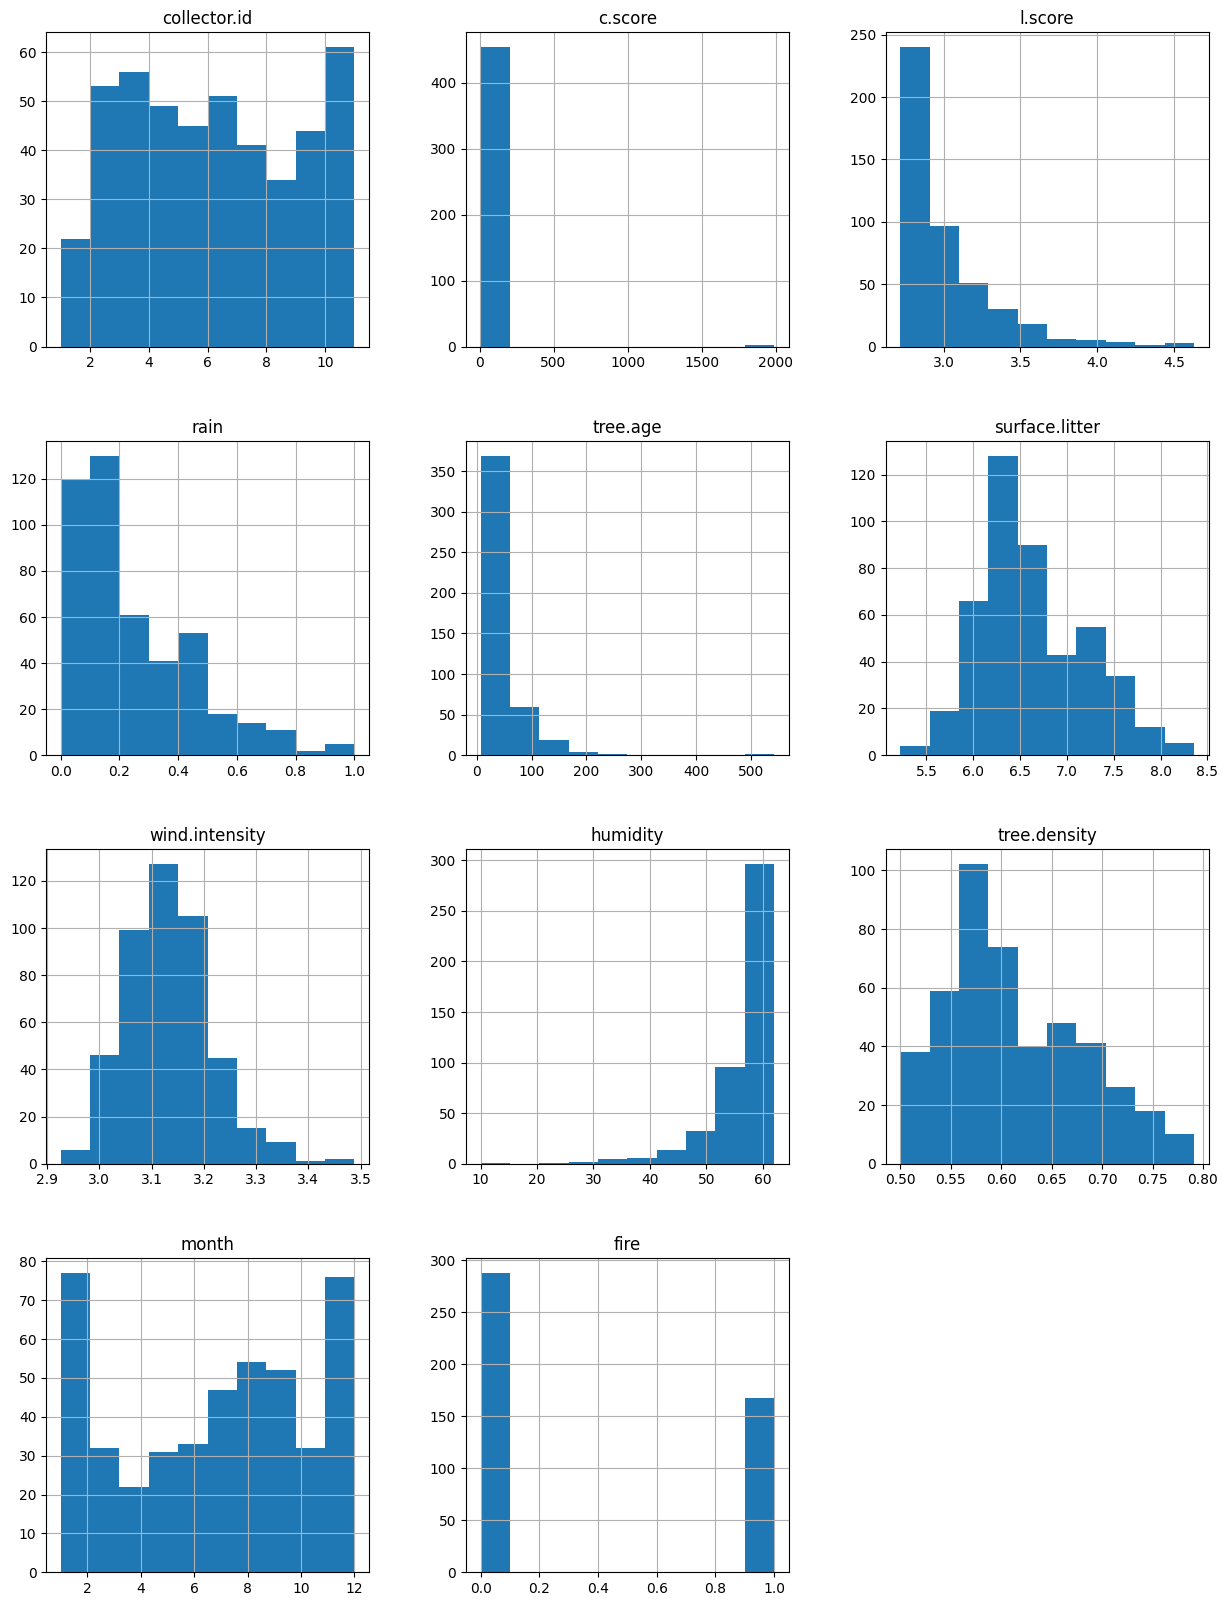

In [9]:
df.hist(figsize = (15,20))

From the previous group of histograms, a serie of ideas can be extracted:

- The column *c.score* contains some outliers (values over 1500), which stop us from seeing its actual distribution. Having said this, it would interesting to remove those values as they might confuse the models and therefore worsen their predictive power.

- The column *tree.age* also contains some outliers (values over 400). These values are correct values (as trees can be over 400 years of age), but as they are so far away from the rest of values it would appropriate to remove them as they will not help the model (trees that old are not that common and they are more likely to burn easier).

- The positive values for the variable (the ones that indicate that there is a fire) are underrepresented in the dataset. This could lead to a model bias towards the negative value of said feature.

Before going to the next step, I would like to point out the fact that the variable *time.of.day* is categorical and might be interesting to one-hot encode it.

In [10]:
df = pd.get_dummies(df, prefix_sep='_', drop_first=True)

---
# Metric Decision

Before building any model, we have to think in what metric we should use to define if the models we are about to build are either good or bad. The problem could (and actually will be by some of our models) treated in two different ways: as a **regression problem** and as a **classification problem**.
Models such as the **Logistic Regression** will predict the probability of a fire ocurring, rather than if a fire will or not occur (in other words, a *regression problem*). For this case it might be interesting to use the **R^2** metric.

The rest of the models (both **DecisionTrees** and **Neural Networks**) will treat the problem as a *classification problem*.

For this case, we need to consider what does the elements of the confussion matrix actually mean for our specific problem:

 - TP: A fire alert for an actual fire.
 - TN: Not a fire alert as there is no actual fire.
 - FP: A fire alert for a fictional fire.
 - FN: Not a fire alert, but there is an actual fire.

As the two main things we want to avoid are *FP* (calling the firefighters, mobilising the operatives, .... which costs quite a lot of money, among other things) and *FN* (as we wouldn't know that there is an actual fire happening, which could have horrible consequences), I will choose the **F1 Score** (or also called the Harmonic Mean of Precision and Recall), as it aims to avoid or reduce both values mentioned.

Although both metrics will be used, the main one to guide the decisions will be the **F1 Score**, **R^2** one the other hand will help to support the reasoning.

---
# Note

To try to find the best model hyperparameters I will use in all cases the *GridSearch* method (which consists of an exhaustive search through the chosen values for some of the hyperparameters of the model) as it is better than *RandomSearch* (which randomly tries different combinations for the hyperparameters) and less time consuming than *ExhaustiveSearch* (which, as its name suggests, tries every single combination of the hyperparameters of a model).

---
# Data Split

Before training the models, it is needed to split the data into at least two different groups (training and test) so that there is no data leakage and the model that is being built can generalize and predict unseen data.

In my case, I will divide the data in 3 different groups: training (which will be used for training the models), validation (which will be used to test all models' performance) and test (which will be used to test if the performance of the model with the highest value of the chosen metric stays the same or gets worse). 

In [11]:
# Set features and targets variables
# Also remove the column collector.id as it brings no relevant information
targetName = "fire"
allFeatureNames = df.columns[df.columns != targetName]
allFeatureNames = allFeatureNames[allFeatureNames != "collector.id"]
# df_nonull = df.dropna()
X = df[allFeatureNames]
y = df[targetName]

In [12]:
# Divide the data in train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [13]:
# Divide the training data again into training and validation
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

Once the data is splitted, I will clean data from the values previously mentioned (mainly outliers and null values).

In [14]:
y_train = y_train[X_train["l.score"].notnull()]
y_train = y_train[X_train["rain"].notnull()]
y_train = y_train[X_train["tree.age"].notnull()]
y_train = y_train[X_train["wind.intensity"].notnull()]
y_train = y_train[X_train["humidity"].notnull()]
X_train.dropna(inplace=True)

In [15]:
y_train = y_train[X_train["c.score"]<100]
X_train = X_train[X_train["c.score"]<100]
y_train = y_train[X_train["tree.age"]<200] 
X_train = X_train[X_train["tree.age"]<200]

In [16]:
X_train.reset_index(drop=True)

,c.score,l.score,rain,tree.age,surface.litter,wind.intensity,humidity,tree.density,month,time.of.day_morning,time.of.day_night
0,12.860,2.828244,0.115060,20.350,6.433101,3.119199,58.0,0.57926,11,True,False
1,14.710,3.120619,0.403728,40.090,6.893149,3.147470,51.0,0.68340,8,True,False
2,13.530,2.918850,0.325845,32.650,6.406055,3.177692,60.0,0.57407,12,False,False
3,9.295,2.811959,0.120328,19.630,5.788736,3.330820,58.0,0.57262,12,False,True
4,17.540,3.031801,0.372167,40.730,7.122060,3.152168,54.0,0.69390,6,False,True
...,...,...,...,...,...,...,...,...,...,...,...
276,11.040,2.818194,0.103082,11.680,6.102782,3.051765,59.0,0.56754,12,False,False
277,11.630,2.927725,0.100249,23.130,6.268717,3.161239,58.0,0.56835,5,True,False
278,9.742,2.748598,0.069930,16.390,5.872681,3.183581,61.0,0.55159,3,True,False
279,11.540,2.755955,0.044269,9.438,6.148041,3.050744,59.0,0.54715,5,False,False


# Clean Data

The first thing I will try is to train the models with the clean data, the data without modification but for those performed in the data cleaning step.

### Logistic Regression

In [17]:
parametersLR = dict(solver=["liblinear","lbfgs","sag",],
                    penalty=['l2'],
                    max_iter=[None, 2000, 5000])

The following line will avoid getting printed some errors like *ConvergenceWarning* that some models might print and would make this notebook less legible.

In [18]:
warnings.filterwarnings('ignore')

In [19]:
lR = LogisticRegression(random_state=1)
lR_clf = GridSearchCV(lR, parametersLR, scoring="f1_macro").fit(X_train, y_train)

In [20]:
y_validation = y_validation[X_validation["l.score"].notnull()]
y_validation = y_validation[X_validation["rain"].notnull()]
y_validation = y_validation[X_validation["tree.age"].notnull()]
y_validation = y_validation[X_validation["wind.intensity"].notnull()]
y_validation = y_validation[X_validation["humidity"].notnull()]
X_validation.dropna(inplace=True)

In [21]:
y_validation = y_validation[X_validation["c.score"]<100] 
X_validation = X_validation[X_validation["c.score"]<100]
y_validation = y_validation[X_validation["tree.age"]<200]
X_validation = X_validation[X_validation["tree.age"]<200]

In [22]:
print(lR_clf.best_params_)
print(round(metrics.f1_score(lR_clf.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.862


In [23]:
print("R2:", metrics.r2_score(y_validation, lR_clf.best_estimator_.predict(X_validation)))

R2: 0.4524999999999999


As the result obtained by the **GridSearch** doesn't look as good as I expected, I will perform some manual search.

**Logistic Regression** with *{'penalty': 'l2', 'solver': 'liblinear'}*

In [24]:
lR1 = LogisticRegression(random_state=1, penalty="l2", solver="liblinear").fit(X_train, y_train)

In [25]:
y_lR1 = lR1.predict_proba(X_validation)[:,1]
y_lR1 = [round(y) for y in y_lR1]
print(round(metrics.f1_score(y_lR1, y_validation, average="macro"), 3))

0.862


**Logistic Regression** with *{'penalty': 'l2', 'solver': 'sag'}*

In [26]:
lR2 = LogisticRegression(random_state=1, penalty="l2", solver="sag").fit(X_train, y_train)

In [27]:
y_lR2 = lR2.predict_proba(X_validation)[:,1]
y_lR2 = [round(y) for y in y_lR2]
print(round(metrics.f1_score(y_lR2, y_validation, average="macro"), 3))

0.862


**Note**: As it can be observed, for some reason the *GridSearch* is not really making an exhaustive search (although it is supposed to). Knowing this, we might have to consider doing some manual iterations over the hyperparameters if the result obtained is not as high as expected.

### Decision Tree

In [28]:
parametersDT = dict(criterion=["gini","entropy","log_loss",],
                    max_depth=[None, 6, 20])

In [29]:
tree_clf = tree.DecisionTreeClassifier(random_state=1)
tree_Grid = GridSearchCV(tree_clf, parametersDT, scoring="f1_macro").fit(X_train, y_train)

In [30]:
print(tree_Grid.best_params_)
print(round(metrics.f1_score(tree_Grid.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'criterion': 'entropy', 'max_depth': None}
0.84


In [32]:
print("R2:", metrics.r2_score(y_validation, tree_Grid.best_estimator_.predict(X_validation)))

R2: 0.3308333333333333


As the result obtained by **GridSearch** doesn't look as good as I expected, I will perform some search manually.

**DecisionTreeClassifier** with *{'criterion':'gini'}*

In [33]:
tree_g = tree.DecisionTreeClassifier(criterion="gini",random_state=1).fit(X_train, y_train)
y_DTC_g = tree_g.predict(X_validation)

In [34]:
print(f"The F1 score (no label imbalance into account) is: {round(metrics.f1_score(y_DTC_g, y_validation, average='macro'),3)}")

The F1 score (no label imbalance into account) is: 0.853


**DecisionTreeClassifier** with *{'criterion':'log_loss'}*

In [35]:
tree_LL = tree.DecisionTreeClassifier(criterion="log_loss",random_state=1).fit(X_train, y_train)
y_DTC_LL = tree_LL.predict(X_validation)

In [36]:
print(f"The F1 score is: {round(metrics.f1_score(y_DTC_LL, y_validation, average='macro'),3)}")

The F1 score is: 0.84


### RandomForest

RandomForest is the bagging (consists of training a number of models in parallel using bootstrapped samples of the data in order to decrease the model's variance) ensemble method of the *Decision Tree Classifier*.

In [37]:
parametersRF = dict(criterion=["gini","entropy","log_loss",],
                    n_estimators=[10,50,100],
                    max_depth=[None, 6, 20])

In [38]:
rf_clf = RandomForestClassifier(random_state=1)
rf_Grid = GridSearchCV(rf_clf, parametersRF, scoring="f1_macro").fit(X_train, y_train)

In [39]:
print(rf_Grid.best_params_)
print(round(metrics.f1_score(rf_Grid.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}
0.876


In [40]:
print("R2:", metrics.r2_score(y_validation, rf_Grid.best_estimator_.predict(X_validation)))

R2: 0.5133333333333332


**RandomForest** with *{'n_estimators'=50,'criterion'='log_loss'}*

In [41]:
rf1 = RandomForestClassifier(n_estimators=50, random_state=1, criterion="log_loss").fit(X_train, y_train)
y_rf1 = rf1.predict(X_validation)

In [42]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf1, y_validation, average='macro'),3)}")

The F1 score is: 0.876


**RandomForest** with *{'n_estimator'=25,'max_depth'=6, 'random_state'=1}*

In [43]:
rf2 = RandomForestClassifier(n_estimators=25, max_depth=6, random_state=1).fit(X_train, y_train)
y_rf2 = rf2.predict(X_validation)

In [44]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf2, y_validation, average='macro'),3)}")

The F1 score is: 0.878


**RandomForest** with *{'n_estimator'=25,'random_state'=1}*

In [45]:
rf3 = RandomForestClassifier(n_estimators=25, random_state=1).fit(X_train, y_train)
y_rf3 = rf3.predict(X_validation)

In [46]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf3, y_validation, average='macro'),3)}")

The F1 score is: 0.845


### Neural Network

In [47]:
parametersNN = dict(activation=["relu","logistic","tanh","identity"],
                    learning_rate_init=[0.001,0.01,0.05],
                    solver=["adam", "sgd", "lbfgs"],
                    max_iter=[200, 800, 1400],
                    hidden_layer_sizes=[(10),(5,5),(5,5,5)])

In [48]:
mlp_clf = MLPClassifier(random_state=1)
mlp_Grid = GridSearchCV(mlp_clf, parametersNN, scoring="f1_macro").fit(X_train, y_train)

In [49]:
print(mlp_Grid.best_params_)
print(round(metrics.f1_score(mlp_Grid.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'activation': 'relu', 'hidden_layer_sizes': (5, 5, 5), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'lbfgs'}
0.87


In [50]:
print("R2:", metrics.r2_score(y_validation, mlp_Grid.best_estimator_.predict(X_validation)))

R2: 0.4524999999999999


As the result obtained by **MLPClassifier** doesn't look as good as I expected, I will perform some search manually.

**MLPClassifier** with *{'solver':'adam','hidden_layer_sizes'=(10),'max_iter'=2000,'activation'='logistic'}*

In [51]:
mlp1 = MLPClassifier(solver='adam', hidden_layer_sizes=(10), max_iter=2000, activation='logistic',random_state=1).fit(X_train, y_train)
y_MLP1 = mlp1.predict(X_validation)

In [52]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP1, y_validation, average='macro'),3)}")

The F1 score is: 0.925


**MLPClassifier** with *{'solver':'lbfgs','hidden_layer_sizes'=(5,5),'activation'='relu'}*

In [53]:
mlp2 = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(5,5), activation='relu',random_state=1).fit(X_train, y_train)
y_MLP2 = mlp2.predict(X_validation)

In [54]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP2, y_validation, average='macro'),3)}")

The F1 score is: 0.862


## Best model for clean data

The best model I could find for the clean data is **MLPClassifier** with the following hyperparameters:
 - 'solver':'adam'
 - 'hidden_layer_sizes':(10)
 - 'max_iter':2000
 - 'activation':'logistic'

To see if the model chosen is actually as good as it seems I will use it to predict the test data and see how good its prediction power.

In [55]:
y_test = y_test[X_test["l.score"].notnull()]
y_test = y_test[X_test["rain"].notnull()]
y_test = y_test[X_test["tree.age"].notnull()]
y_test = y_test[X_test["wind.intensity"].notnull()]
y_test = y_test[X_test["humidity"].notnull()]
X_test.dropna(inplace=True)

In [56]:
y_cleanBest = mlp1.predict(X_test)

In [57]:
print(round(metrics.f1_score(y_cleanBest, y_test, average="macro"), 3))

0.93


In [58]:
print("R2:", metrics.r2_score(y_test, y_cleanBest))

R2: 0.7224532224532225


As it can be appreciated, its predictive performance didn't worsen, in fact it improved a little bit. This could be a sign of being a good and solid model, as it predicted unseen data pretty accurately.

# Filling null values with median

As detected in previous steps, there are some nulls value in some of the values. The previous models were trained without them. In this step, I will fill said values with the median (as it is a more stable measure than the mean).

In [59]:
targetName = "fire"
allFeatureNames = df.columns[df.columns != targetName]
allFeatureNames = allFeatureNames[allFeatureNames != "collector.id"]
X = df[allFeatureNames]
y = df[targetName]

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [61]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [62]:
# Fill the null values of the columns with the median of that column
X_train['l.score'] = X_train['l.score'].fillna(X_train['l.score'].median())
X_train['rain'] = X_train['rain'].fillna(X_train['rain'].median())
X_train['tree.age'] = X_train['tree.age'].fillna(X_train['tree.age'].median())
X_train['wind.intensity'] = X_train['wind.intensity'].fillna(X_train['wind.intensity'].median())
X_train['humidity'] = X_train['humidity'].fillna(X_train['humidity'].median())

In [63]:
y_train = y_train[X_train["c.score"]<100] 
X_train = X_train[X_train["c.score"]<100]
y_train = y_train[X_train["tree.age"]<200] 
X_train = X_train[X_train["tree.age"]<200]

### Logistic Regression

In [64]:
parametersLR = dict(solver=["liblinear","lbfgs","sag",],
                    penalty=['l2'],
                    max_iter=[None, 2000, 5000])

In [65]:
lR_median = LogisticRegression(random_state=1)
lR_clf_median = GridSearchCV(lR_median, parametersLR, scoring="f1_macro").fit(X_train, y_train)

As with the training dataset, we have to apply the same transformations for the validation dataset.

In [66]:
X_validation['l.score'] = X_validation['l.score'].fillna(X_validation['l.score'].median())
X_validation['rain'] = X_validation['rain'].fillna(X_validation['rain'].median())
X_validation['tree.age'] = X_validation['tree.age'].fillna(X_validation['tree.age'].median())
X_validation['wind.intensity'] = X_validation['wind.intensity'].fillna(X_validation['wind.intensity'].median())
X_validation['humidity'] = X_validation['humidity'].fillna(X_validation['humidity'].median())

In [67]:
y_validation = y_validation[X_validation["c.score"]<100] 
X_validation = X_validation[X_validation["c.score"]<100]
y_validation = y_validation[X_validation["tree.age"]<200] 
X_validation = X_validation[X_validation["tree.age"]<200]

In [68]:
print(lR_clf_median.best_params_)
print(round(metrics.f1_score(lR_clf_median.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}
0.862


In [69]:
print("R2:", metrics.r2_score(y_validation, lR_clf_median.best_estimator_.predict(X_validation)))

R2: 0.4524999999999999


Although the **Logistic Regression** model seems to have improved with this new modification, I will try some manual hyperparameter search as the *GridSearch* method has been proved to not perform an exhaustive search.

**Logistic Regression** with *{'penalty': 'l2', 'solver': 'sag'}*

In [70]:
lR2_median = LogisticRegression(random_state=1, penalty="l2", solver="sag").fit(X_train, y_train)

In [71]:
y_lR2_median = lR2_median.predict_proba(X_validation)[:,1]
y_lR2_median = [round(y) for y in y_lR2_median]
print(round(metrics.f1_score(y_lR2_median, y_validation, average="macro"), 3))

0.862


### Decision Tree

In [72]:
parametersDT = dict(criterion=["gini","entropy","log_loss",],
                    max_depth=[None, 6, 20])

In [73]:
tree_clf_median = tree.DecisionTreeClassifier(random_state=1)
tree_Grid_median = GridSearchCV(tree_clf_median, parametersDT, scoring="f1_macro").fit(X_train, y_train)

In [74]:
print(tree_Grid_median.best_params_)
print(round(metrics.f1_score(tree_Grid_median.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'criterion': 'gini', 'max_depth': None}
0.853


In [75]:
print("R2:", metrics.r2_score(y_validation, tree_Grid_median.best_estimator_.predict(X_validation)))

R2: 0.3916666666666666


As the result obtained by **GridSearch** doesn't look as good as I expected, I will perform some search manually.

**DecisionTreeClassifier** with *{'criterion':'gini'}*

In [76]:
tree_g_median = tree.DecisionTreeClassifier(criterion="gini",random_state=1).fit(X_train, y_train)
y_DTC_g_median = tree_g_median.predict(X_validation)

In [77]:
print(f"The F1 score is: {round(metrics.f1_score(y_DTC_g_median, y_validation, average='macro'),3)}")

The F1 score is: 0.853


**DecisionTreeClassifier** with *{'criterion':'log_loss'}*

In [78]:
tree_LL_median = tree.DecisionTreeClassifier(criterion="log_loss",random_state=1).fit(X_train, y_train)
y_DTC_LL_median = tree_LL_median.predict(X_validation)

In [79]:
print(f"The F1 score is: {round(metrics.f1_score(y_DTC_LL_median, y_validation, average='macro'),3)}")

The F1 score is: 0.84


### RandomForest

In [80]:
parametersRF = dict(criterion=["gini","entropy","log_loss",],
                    n_estimators=[10,50,100],
                    max_depth=[None, 6, 20])

In [81]:
rf_clf_median = RandomForestClassifier(random_state=1)
rf_Grid_median = GridSearchCV(rf_clf_median, parametersRF, scoring="f1_macro").fit(X_train, y_train)

In [82]:
print(rf_Grid_median.best_params_)
print(round(metrics.f1_score(rf_Grid_median.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}
0.859


In [83]:
print("R2:", metrics.r2_score(y_validation, rf_Grid_median.best_estimator_.predict(X_validation)))

R2: 0.4524999999999999


**RandomForest** with *{'n_estimators'=50,'criterion'='log_loss'}*

In [84]:
rf1_median = RandomForestClassifier(n_estimators=50, random_state=1, criterion="log_loss").fit(X_train, y_train)
y_rf1_median = rf1_median.predict(X_validation)

In [85]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf1_median, y_validation, average='macro'),3)}")

The F1 score is: 0.859


**RandomForest** with *{'n_estimator'=25, 'random_state'=1}*

In [86]:
rf2_median = RandomForestClassifier(n_estimators=25, random_state=1).fit(X_train, y_train)
y_rf2_median = rf2_median.predict(X_validation)

In [87]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf2_median, y_validation, average='macro'),3)}")

The F1 score is: 0.876


**RandomForest** with *{'n_estimator'=50,'max_depth'=6,'criterion'='entropy','random_state'=1}*

In [88]:
rf3_median = RandomForestClassifier(n_estimators=50, max_depth=6, criterion='entropy',random_state=1).fit(X_train, y_train)
y_rf3_median = rf3_median.predict(X_validation)

In [89]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf3_median, y_validation, average='macro'),3)}")

The F1 score is: 0.876


### Neural Network

In [90]:
parametersNN = dict(activation=["relu","logistic","tanh","identity"],
                    learning_rate_init=[0.001,0.01,0.05],
                    solver=["adam", "sgd", "lbfgs"],
                    max_iter=[200, 800, 1400],
                    hidden_layer_sizes=[(10),(5,5),(5,5,5)])

In [91]:
mlp_clf_median = MLPClassifier(random_state=1)
mlp_Grid_median = GridSearchCV(mlp_clf_median, parametersNN, scoring="f1_macro").fit(X_train, y_train)

In [92]:
print(mlp_Grid_median.best_params_)
print(round(metrics.f1_score(mlp_Grid_median.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'activation': 'identity', 'hidden_layer_sizes': (5, 5), 'learning_rate_init': 0.001, 'max_iter': 800, 'solver': 'lbfgs'}
0.862


In [93]:
print("R2:", metrics.r2_score(y_validation, mlp_Grid_median.best_estimator_.predict(X_validation)))

R2: 0.4524999999999999


As the result obtained by **MLPClassifier** doesn't look as good as I expected, I will perform some search manually.

**MLPClassifier** with *{'solver':'adam','hidden_layer_sizes'=(10),'max_iter'=2000,'activation'='logistic'}*

In [94]:
mlp1_median = MLPClassifier(solver='adam', hidden_layer_sizes=(10), max_iter=2000, activation='logistic',random_state=1).fit(X_train, y_train)
y_MLP1_median = mlp1_median.predict(X_validation)

In [95]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP1_median, y_validation, average='macro'),3)}")

The F1 score is: 0.925


**MLPClassifier** with *{'solver':'lbfgs','hidden_layer_sizes'=(5,5),'activation'='relu'}*

In [96]:
mlp2_median = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(5,5), activation='relu',random_state=1).fit(X_train, y_train)
y_MLP2_median = mlp2_median.predict(X_validation)

In [97]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP2_median, y_validation, average='macro'),3)}")

The F1 score is: 0.881


## Best model for filled null values

The best model I could find for the data where the null values were filled we the column's median is **MLPClassifier** with the following hyperparameters:
- 'solver':'adam'
- 'hidden_layer_sizes':(10)
- 'activation':'logistic'
- 'max_iter':2000


To see if the model chosen is actually as good as it seems I will use it to predict the test data and see how good its prediction power.

As the **MLPClassifier** does not accept null values natively, I will perform the same modification on the test dataset to the one performed to the training and test datasets.

In [98]:
X_test['l.score'] = X_test['l.score'].fillna(X_test['l.score'].median())
X_test['rain'] = X_test['rain'].fillna(X_test['rain'].median())
X_test['tree.age'] = X_test['tree.age'].fillna(X_test['tree.age'].median())
X_test['wind.intensity'] = X_test['wind.intensity'].fillna(X_test['wind.intensity'].median())
X_test['humidity'] = X_test['humidity'].fillna(X_test['humidity'].median())

In [99]:
y_filledBest = mlp1_median.predict(X_test)

In [100]:
print(round(metrics.f1_score(y_filledBest, y_test, average='macro'),3))

0.943


In [101]:
print("R2:", metrics.r2_score(y_test, y_filledBest))

R2: 0.7758284600389863


As both the **F1 Score** and **R^2** metrics are higher with the null values filled with the median of said columns, I will use this transformation for posterior steps. 

## Normalized Data

In this step the models will be built from the data after normalising all the variables. For it, I will be using the *MinMaxScaler* which rescales the data such that all the features values are in the range of [0,1].

Note that here it is important to do it after the splitting for the dataset and not before as some normalization methods take into account the maximum and minimum values of the data.

In [102]:
mm_scaler = MinMaxScaler()
X_train_norm = pd.DataFrame(mm_scaler.fit_transform(X_train), columns=X_train.columns)

### Logistic Regression

In [103]:
parametersLR = dict(solver=["liblinear","lbfgs","sag",],
                    penalty=['l2'],
                    max_iter=[None, 2000, 5000])

In [104]:
lR_norm = LogisticRegression(random_state=1)
lR_clf_norm = GridSearchCV(lR, parametersLR, scoring="f1_macro").fit(X_train_norm, y_train)

In [105]:
X_validation_norm = pd.DataFrame(mm_scaler.fit_transform(X_validation), columns=X_validation.columns)

In [106]:
print(lR_clf_norm.best_params_)
print(round(metrics.f1_score(lR_clf_norm.best_estimator_.predict(X_validation_norm), y_validation, average="macro"), 3))

{'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.841


In [107]:
print("R2:", metrics.r2_score(y_validation, lR_clf_norm.best_estimator_.predict(X_validation_norm)))

R2: 0.3916666666666666


As in previous steps, I will try some manual search before trying the next model.

**Logistic Regression** with *{'penalty': 'l2', 'solver': 'liblinear'}*

In [108]:
lR2_norm = LogisticRegression(random_state=1, penalty="l2", solver="liblinear").fit(X_train_norm, y_train)

In [109]:
y_lR2_norm = lR2_norm.predict_proba(X_validation_norm)[:,1]
y_lR2_norm = [round(y) for y in y_lR2_norm ]
print(round(metrics.f1_score(y_lR2_norm, y_validation, average="macro"), 3))

0.859


### Decision Tree Classifier

In [110]:
parametersDT = dict(criterion=["gini","entropy","log_loss",],
                    max_depth=[None, 6, 20])

In [111]:
tree_clf_norm = tree.DecisionTreeClassifier(random_state=1)
tree_Grid_norm = GridSearchCV(tree_clf_norm, parametersDT, scoring="f1_macro").fit(X_train_norm, y_train)

In [112]:
print(tree_Grid_norm.best_params_)
print(round(metrics.f1_score(tree_Grid_norm.best_estimator_.predict(X_validation_norm), y_validation, average="macro"), 3))

{'criterion': 'gini', 'max_depth': None}
0.892


In [113]:
print("R2:", metrics.r2_score(y_validation, tree_Grid_norm.best_estimator_.predict(X_validation_norm)))

R2: 0.5741666666666666


**Manual Search** of hyperparameters

**DecisionTreeClassifier** with *{'criterion':'log_loss'}*

In [114]:
tree_LL_norm = tree.DecisionTreeClassifier(criterion="log_loss",random_state=1).fit(X_train_norm, y_train)
y_DTC_LL_norm = tree_LL_norm.predict(X_validation_norm)

In [115]:
print(f"The F1 score is: {round(metrics.f1_score(y_DTC_LL_norm, y_validation, average='macro'),3)}")

The F1 score is: 0.878


### RandomForest

In [116]:
parametersRF = dict(criterion=["gini","entropy","log_loss",],
                    n_estimators=[10,50,100],
                    max_depth=[None, 6, 20])

In [117]:
rf_clf_norm = RandomForestClassifier(random_state=1)
rf_Grid_norm = GridSearchCV(rf_clf_norm, parametersRF, scoring="f1_macro").fit(X_train_norm, y_train)

In [118]:
print(rf_Grid_norm.best_params_)
print(round(metrics.f1_score(rf_Grid_norm.best_estimator_.predict(X_validation_norm), y_validation, average="macro"), 3))

{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}
0.841


In [119]:
print("R2:", metrics.r2_score(y_validation, rf_Grid_norm.best_estimator_.predict(X_validation)))

R2: -1.9200000000000004


**Manual Search** for *RandomForest* hyperparameters

**RandomForest** with *{'n_estimator'=50,'max_depth'=6,'criterion'='entropy','random_state'=1}*

In [120]:
rf3_norm = RandomForestClassifier(n_estimators=50, max_depth=6, criterion='entropy',random_state=1).fit(X_train_norm, y_train)
y_rf3_norm = rf3_norm.predict(X_validation_norm)

In [121]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf3_norm, y_validation, average='macro'),3)}")

The F1 score is: 0.859


### Neural Network

In [122]:
parametersNN = dict(activation=["relu","logistic","tanh","identity"],
                    learning_rate_init=[0.001,0.01,0.05],
                    solver=["adam", "sgd", "lbfgs"],
                    max_iter=[200, 800, 1400],
                    hidden_layer_sizes=[(10),(5,5),(5,5,5)])

In [123]:
mlp_clf_norm = MLPClassifier(random_state=1)
mlp_Grid_norm = GridSearchCV(mlp_clf_norm, parametersNN, scoring="f1_macro").fit(X_train_norm, y_train)

In [124]:
print(mlp_Grid_norm.best_params_)
print(round(metrics.f1_score(mlp_Grid_norm.best_estimator_.predict(X_validation_norm), y_validation, average="macro"), 3))

{'activation': 'relu', 'hidden_layer_sizes': (5, 5, 5), 'learning_rate_init': 0.05, 'max_iter': 200, 'solver': 'sgd'}
0.876


In [125]:
print("R2:", metrics.r2_score(y_validation, mlp_Grid_norm.best_estimator_.predict(X_validation_norm)))

R2: 0.5133333333333332


**Manual Search** of hyperparameters for the *MLPClassifier*

**MLPClassifier** with *{'solver':'adam','hidden_layer_sizes'=(10),'max_iter'=2000,'activation'='logistic'}*

In [126]:
mlp1_norm = MLPClassifier(solver='adam', hidden_layer_sizes=(10), max_iter=2000, activation='logistic',random_state=1).fit(X_train_norm, y_train)
y_MLP1_norm = mlp1_norm.predict(X_validation_norm)

In [127]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP1_norm, y_validation, average='macro'),3)}")

The F1 score is: 0.859


**MLPClassifier** with *{'solver':'lbfgs','hidden_layer_sizes'=(5,5),'activation'='relu'}*

In [128]:
mlp2_norm = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(5,5), activation='relu',random_state=1).fit(X_train_norm, y_train)
y_MLP2_norm = mlp2_norm.predict(X_validation_norm)

In [129]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP2_norm, y_validation, average='macro'),3)}")

The F1 score is: 0.859


## Best model for normalized data

The best model I could find for the clean data is a **DecisionTreeClassifier**, but they are models that know for their instability I will use the next best model which is an **MLPClassifier** with the following hyperparameters:
- 'activation': 'relu'
- 'hidden_layer_sizes': (5, 5, 5)
- 'learning_rate_init': 0.05
- 'max_iter': 200
- 'solver': 'sgd'

To see if the model chosen is actually as good as it seems I will use it to predict the test data and see how good its prediction power.

In [130]:
scaler = MinMaxScaler()
X_test_norm = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

In [131]:
y_normBest = mlp_Grid_norm.best_estimator_.predict(X_test_norm)

In [132]:
print(round(metrics.f1_score(y_normBest, y_test, average='macro'),3))

0.955


In [133]:
print("R2:", metrics.r2_score(y_test, y_normBest))

R2: 0.8206627680311891


As the results of both metrics are better than the ones obtained with the unnormalized data, **I will normalize** the data for following steps.

---

# Uncorrelated Data

In this step the models will be built from the data after taking out some of the highly correlated vairables. As the models built from the normalised data turned out to be an improvement from the models built from the base dataset, I will normalize the data for this step. 

To find out which variables have correlation between them, I will use a coloured correlation matrix where a dark red square means that two variables (the one in the column and the one in the row) are highly positively correlated. If, on the other hand, the square is dark blue, it means that the two variables are highly negatively correlated.

**Note**: The variable *time.of.day* will not be used to create the correlation matrix as it is a column that contains strings and, if used, an error arises.

In [134]:
df.corr().style.background_gradient(cmap='coolwarm')

,collector.id,c.score,l.score,rain,tree.age,surface.litter,wind.intensity,humidity,tree.density,month,fire,time.of.day_morning,time.of.day_night
collector.id,1.000000,-0.050264,-0.007252,0.004176,-0.001664,0.017166,0.014691,0.070920,0.006196,0.040819,0.003607,0.000306,-0.011791
c.score,-0.050264,1.000000,0.010255,0.012243,-0.009639,0.015894,-0.040875,0.009082,0.013457,-0.000791,-0.031894,-0.044736,0.016421
l.score,-0.007252,0.010255,1.000000,0.905248,0.637844,0.653907,0.431780,-0.676025,0.824831,0.085508,0.564577,0.025705,0.014433
rain,0.004176,0.012243,0.905248,1.000000,0.693742,0.818463,0.468918,-0.607190,0.917459,0.122157,0.684050,0.022692,0.000852
tree.age,-0.001664,-0.009639,0.637844,0.693742,1.000000,0.708016,0.135609,-0.251645,0.551867,0.118422,0.501015,-0.004164,0.016439
surface.litter,0.017166,0.015894,0.653907,0.818463,0.708016,1.000000,0.218637,-0.418690,0.800077,0.141633,0.720805,0.069285,-0.022637
wind.intensity,0.014691,-0.040875,0.431780,0.468918,0.135609,0.218637,1.000000,-0.528254,0.554210,0.016844,0.330339,0.053640,-0.059502
humidity,0.070920,0.009082,-0.676025,-0.607190,-0.251645,-0.418690,-0.528254,1.000000,-0.719598,-0.038235,-0.434149,-0.076432,0.018143
tree.density,0.006196,0.013457,0.824831,0.917459,0.551867,0.800077,0.554210,-0.719598,1.000000,0.111694,0.698306,0.054802,-0.008810
month,0.040819,-0.000791,0.085508,0.122157,0.118422,0.141633,0.016844,-0.038235,0.111694,1.000000,0.196339,-0.009740,-0.009222


As it can be appreciated, there are a couple variables which are highly correlated: *c.score*-*surface.litter* and *rain*-*tree.density*. I will train the models 3 times: the first training will be without the *surface.litter* variable, the second one will be without *rain* and the last one will be without both.

This last step will help decide if the model improves or not its performance without the two most correlated variables.

It can also be appreciated that the least correlated variables are: *c.score*-*month* and *c.score*-*humidity*. I will also train the models without said variables and see if their performance improves.

## Data without *c.score*

In [135]:
targetName = "fire"
allFeatureNames = df.columns[df.columns != targetName]
allFeatureNames = allFeatureNames[allFeatureNames != "collector.id"]
allFeatureNames = allFeatureNames[allFeatureNames != "c.score"]
X = df[allFeatureNames]
y = df[targetName]

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [137]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [138]:
y_train = y_train[X_train["l.score"].notnull()]
y_train = y_train[X_train["rain"].notnull()]
y_train = y_train[X_train["tree.age"].notnull()]
y_train = y_train[X_train["wind.intensity"].notnull()]
y_train = y_train[X_train["humidity"].notnull()]
X_train.dropna(inplace=True)

In [139]:
y_train = y_train[X_train["tree.age"]<200] 
X_train = X_train[X_train["tree.age"]<200]

In [140]:
mm_scaler = MinMaxScaler()
X_train = pd.DataFrame(mm_scaler.fit_transform(X_train), columns=X_train.columns)

### Logistic Regression

In [141]:
parametersLR = dict(solver=["liblinear","lbfgs","sag",],
                    penalty=['l2'],
                    max_iter=[None, 2000, 5000])

In [142]:
lR_uncorr1 = LogisticRegression(random_state=1)
lR_clf_uncorr1 = GridSearchCV(lR_uncorr1, parametersLR, scoring="f1_macro").fit(X_train, y_train)

In [143]:
y_validation = y_validation[X_validation["l.score"].notnull()]
y_validation = y_validation[X_validation["rain"].notnull()]
y_validation = y_validation[X_validation["tree.age"].notnull()]
y_validation = y_validation[X_validation["wind.intensity"].notnull()]
y_validation = y_validation[X_validation["humidity"].notnull()]
X_validation.dropna(inplace=True)

In [144]:
y_validation = y_validation[X_validation["tree.age"]<200]
X_validation = X_validation[X_validation["tree.age"]<200]

In [145]:
mm_scaler = MinMaxScaler()
X_validation = pd.DataFrame(mm_scaler.fit_transform(X_validation), columns=X_validation.columns)

In [146]:
print(lR_clf_uncorr1.best_params_)
print(round(metrics.f1_score(lR_clf_uncorr1.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.841


In [147]:
print("R2:", metrics.r2_score(y_validation, lR_clf_uncorr1.best_estimator_.predict(X_validation)))

R2: 0.3916666666666666


**Manual Search** of hyperparameters

**Logistic Regression** with *{'solver':'sag','penalty':'l2','max_iter':5000}*

In [148]:
lR2_uncorr1 = LogisticRegression(solver='sag', penalty='l2', max_iter=5000, random_state=1).fit(X_train, y_train)
y_lR2_uncorr1 = lR2_uncorr1.predict_proba(X_validation)[:,1]
y_lR2_uncorr1 = [round(y) for y in y_lR2_uncorr1]

In [149]:
print(f"The F1 score is: {round(metrics.f1_score(y_lR2_uncorr1, y_validation, average='macro'),3)}")

The F1 score is: 0.841


**Logistic Regression** with *{'solver':'liblinear','penalty':'l2'}*

In [150]:
lR3_uncorr1 = LogisticRegression(solver='liblinear', penalty='l2', random_state=1).fit(X_train, y_train)
y_lR3_uncorr1 = lR3_uncorr1.predict_proba(X_validation)[:,1]
y_lR3_uncorr1 = [round(y) for y in y_lR3_uncorr1]

In [151]:
print(f"The F1 score is: {round(metrics.f1_score(y_lR3_uncorr1, y_validation, average='macro'),3)}")

The F1 score is: 0.859


**Logistic Regression** with default hyperparameters (*{'penalty':'l2','solver':'lbfgs','max_iter':100}*)

In [152]:
lR4_uncorr1 = LogisticRegression(random_state=1).fit(X_train, y_train)
y_lR4_uncorr1 = lR4_uncorr1.predict_proba(X_validation)[:,1]
y_lR4_uncorr1 = [round(y) for y in y_lR4_uncorr1]

In [153]:
print(f"The F1 score is: {round(metrics.f1_score(y_lR4_uncorr1, y_validation, average='macro'),3)}")

The F1 score is: 0.841


### Decision Tree

In [154]:
parametersDT = dict(criterion=["gini","entropy","log_loss",],
                    max_depth=[None, 6, 20])

In [155]:
tree_clf_uncorr1 = tree.DecisionTreeClassifier(random_state=1)
tree_Grid_uncorr1 = GridSearchCV(tree_clf_uncorr1, parametersDT, scoring="f1_macro").fit(X_train, y_train)

In [156]:
print(tree_Grid_uncorr1.best_params_)
print(round(metrics.f1_score(tree_Grid_uncorr1.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'criterion': 'entropy', 'max_depth': 6}
0.895


In [157]:
print("R2:", metrics.r2_score(y_validation, tree_Grid_uncorr1.best_estimator_.predict(X_validation)))

R2: 0.5741666666666666


**Manual Search** of hyperparameters

**DecisionTree** with hyperparameters *{'criterion':'gini'}*

In [158]:
tree_clf1_uncorr1 = tree.DecisionTreeClassifier(criterion="gini",random_state=1).fit(X_train, y_train)
y_DTC1_uncorr1 = tree_clf1_uncorr1.predict(X_validation)

In [159]:
print(f"The F1 score is: {round(metrics.f1_score(y_DTC1_uncorr1, y_validation, average='macro'),3)}")

The F1 score is: 0.831


**DecisionTree** with hyperparameters *{'criterion':'log_loss'}*

In [160]:
tree_clf3_uncorr1 = tree.DecisionTreeClassifier(criterion="log_loss",random_state=1).fit(X_train, y_train)
y_DTC3_uncorr1 = tree_clf3_uncorr1.predict(X_validation)

In [161]:
print(f"The F1 score is: {round(metrics.f1_score(y_DTC3_uncorr1, y_validation, average='macro'),3)}")

The F1 score is: 0.851


**DecisionTree** with hyperparameters *{'criterion':'gini','max_depth':6}*

In [162]:
tree_clf2_uncorr1 = tree.DecisionTreeClassifier(criterion="gini",max_depth=6,random_state=1).fit(X_train, y_train)
y_DTC2_uncorr1 = tree_clf2_uncorr1.predict(X_validation)

In [163]:
print(f"The F1 score is: {round(metrics.f1_score(y_DTC2_uncorr1, y_validation, average='macro'),3)}")

The F1 score is: 0.876


### RandomForest

In [164]:
parametersRF = dict(criterion=["gini","entropy","log_loss",],
                    n_estimators=[10,50,100],
                    max_depth=[None, 6, 20])

In [165]:
rf_clf_uncorr1 = RandomForestClassifier(random_state=1)
rf_Grid_uncorr1 = GridSearchCV(rf_clf_uncorr1, parametersRF, scoring="f1_macro").fit(X_train, y_train)

In [166]:
print(rf_Grid_uncorr1.best_params_)
print(round(metrics.f1_score(rf_Grid_uncorr1.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'criterion': 'gini', 'max_depth': 6, 'n_estimators': 10}
0.841


In [167]:
print("R2:", metrics.r2_score(y_validation, rf_Grid_uncorr1.best_estimator_.predict(X_validation)))

R2: 0.3916666666666666


**RandomForest** with *{'n_estimators'=50,'criterion'='log_loss'}*

In [168]:
rf1_uncorr1 = RandomForestClassifier(n_estimators=50, random_state=1, criterion="log_loss").fit(X_train, y_train)
y_rf1_uncorr1 = rf1_uncorr1.predict(X_validation)

In [169]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf1_uncorr1, y_validation, average='macro'),3)}")

The F1 score is: 0.841


**RandomForest** with *{'n_estimator'=25}*

In [170]:
rf2_uncorr1 = RandomForestClassifier(n_estimators=25, random_state=1).fit(X_train, y_train)
y_rf2_uncorr1 = rf2_uncorr1.predict(X_validation)

In [171]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf2_uncorr1, y_validation, average='macro'),3)}")

The F1 score is: 0.841


**RandomForest** with *{'n_estimator'=50,'max_depth'=6,'criterion'='entropy','random_state'=1}*

In [172]:
rf3_uncorr1 = RandomForestClassifier(n_estimators=50, max_depth=6, criterion='entropy',random_state=1).fit(X_train, y_train)
y_rf3_uncorr1 = rf3_uncorr1.predict(X_validation)

In [173]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf3_uncorr1, y_validation, average='macro'),3)}")

The F1 score is: 0.841


### Neural Networks

In [174]:
parametersNN = dict(activation=["relu","logistic","tanh","identity"],
                    learning_rate_init=[0.001,0.01,0.05],
                    solver=["adam", "sgd", "lbfgs"],
                    max_iter=[200, 800, 1400],
                    hidden_layer_sizes=[(10),(5,5),(5,5,5)])

In [175]:
mlp_clf_uncorr1 = MLPClassifier(random_state=1)
mlp_Grid_uncorr1 = GridSearchCV(mlp_clf_uncorr1, parametersNN, scoring="f1_macro").fit(X_train, y_train)

In [176]:
print(mlp_Grid_uncorr1.best_params_)
print(round(metrics.f1_score(mlp_Grid_uncorr1.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'activation': 'tanh', 'hidden_layer_sizes': (5, 5), 'learning_rate_init': 0.05, 'max_iter': 200, 'solver': 'adam'}
0.876


In [177]:
print("R2:", metrics.r2_score(y_validation, mlp_Grid_uncorr1.best_estimator_.predict(X_validation)))

R2: 0.5133333333333332


**Manual Search** of hyperparameter

**MLPClassifier** with hyperparameters *{'solver':'adam','hidden_layer_sizes':(5,5),'max_iter':2000,'activations':'logistic'}*

In [178]:
mlp1_uncorr1 = MLPClassifier(solver='adam', hidden_layer_sizes=(5,5), max_iter=2000, activation='logistic', random_state=1).fit(X_train, y_train)
y_MLP1_uncorr1 = mlp1_uncorr1.predict(X_validation)

In [179]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP1_uncorr1, y_validation, average='macro'),3)}")

The F1 score is: 0.859


**MLPClassifier** with hyperparameters *{'solver':'relu','hidden_layer_sizes':(10),'activation':'logistic'}*

In [180]:
mlp2_uncorr1 = MLPClassifier(solver='adam', hidden_layer_sizes=(10), activation='relu', random_state=1).fit(X_train, y_train)
y_MLP2_uncorr1 = mlp2_uncorr1.predict(X_validation)

In [181]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP2_uncorr1, y_validation, average='macro'),3)}")

The F1 score is: 0.859


**MLPClassifer** with hyperparameters *{'solver':'lbfgs','hidden_layer_sizes':10,'activation':'relu', 'learning_rate_init':0.01}*

In [182]:
mlp3_uncorr1 = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10), activation='relu', learning_rate_init= 0.01, random_state=1).fit(X_train, y_train)
y_MLP3_uncorr1 = mlp3_uncorr1.predict(X_validation)

In [183]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP3_uncorr1, y_validation, average='macro'),3)}")

The F1 score is: 0.895


## Best model for data without *c.score*

The best model I could find for the data without the column *c.score* is **MLPClassifier** with the following hyperparameters:
 - 'solver'='lbfgs'
 - 'hidden_layer_sizes'=(10)
 - 'activation'='relu'
 - 'learning_rate_init': 0.001
 - 'max_iter': 200

To see if the model chosen is actually as good as it seems I will use it to predict the test data and see how good its prediction power.

As the **MLPClassifier** does not accept null values natively, I will perform the same modification on the test dataset to the one performed to the training and test datasets.

In [184]:
y_test = y_test[X_test["l.score"].notnull()]
y_test = y_test[X_test["rain"].notnull()]
y_test = y_test[X_test["tree.age"].notnull()]
y_test = y_test[X_test["wind.intensity"].notnull()]
y_test = y_test[X_test["humidity"].notnull()]
X_test.dropna(inplace=True)

In [185]:
mm_scaler = MinMaxScaler()
X_test = pd.DataFrame(mm_scaler.fit_transform(X_test), columns=X_test.columns)

In [186]:
y_uncorr1_Best = mlp3_uncorr1.predict(X_test)

In [187]:
print(round(metrics.f1_score(y_uncorr1_Best, y_test, average='macro'),3))

0.897


In [188]:
print("R2:", metrics.r2_score(y_test, y_uncorr1_Best))

R2: 0.5836798336798338


As both the **F1 Score** and **R^2** metrics are lower without the column *c.score*, it might be interesting to keep this feature in the dataset. 

---

## Data without the variable *rain*

In [189]:
targetName = "fire"
allFeatureNames = df.columns[df.columns != targetName]
allFeatureNames = allFeatureNames[allFeatureNames != "collector.id"]
allFeatureNames = allFeatureNames[allFeatureNames != "rain"]
X = df[allFeatureNames]
y = df[targetName]

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [191]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [192]:
y_train = y_train[X_train["l.score"].notnull()]
y_train = y_train[X_train["tree.age"].notnull()]
y_train = y_train[X_train["wind.intensity"].notnull()]
y_train = y_train[X_train["humidity"].notnull()]
X_train.dropna(inplace=True)

In [193]:
y_train = y_train[X_train["c.score"]<100] 
X_train = X_train[X_train["c.score"]<100]
y_train = y_train[X_train["tree.age"]<200] 
X_train = X_train[X_train["tree.age"]<200]

In [194]:
mm_scaler = MinMaxScaler()
X_train = pd.DataFrame(mm_scaler.fit_transform(X_train), columns=X_train.columns)

### Logistic Regression

In [195]:
parametersLR = dict(solver=["liblinear","lbfgs","sag",],
                    penalty=['l2'],
                    max_iter=[None, 2000, 5000])

In [196]:
lR_uncorr2 = LogisticRegression(random_state=1)
lR_clf_uncorr2 = GridSearchCV(lR_uncorr2, parametersLR, scoring="f1_macro").fit(X_train, y_train)

In [197]:
y_validation = y_validation[X_validation["l.score"].notnull()]
y_validation = y_validation[X_validation["tree.age"].notnull()]
y_validation = y_validation[X_validation["wind.intensity"].notnull()]
y_validation = y_validation[X_validation["humidity"].notnull()]
X_validation.dropna(inplace=True)

In [198]:
y_validation = y_validation[X_validation["c.score"]<100] 
X_validation = X_validation[X_validation["c.score"]<100]
y_validation = y_validation[X_validation["tree.age"]<200]
X_validation = X_validation[X_validation["tree.age"]<200]

In [199]:
mm_scaler = MinMaxScaler()
X_validation = pd.DataFrame(mm_scaler.fit_transform(X_validation), columns=X_validation.columns)

In [200]:
print(lR_clf_uncorr2.best_params_)
print(round(metrics.f1_score(lR_clf_uncorr2.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.841


In [201]:
print("R2:", metrics.r2_score(y_validation, lR_clf_uncorr2.best_estimator_.predict(X_validation)))

R2: 0.3916666666666666


**Manual Search** of hyperparameters

**Logistic Regression** with *{'solver':'sag','penalty':'l2','max_iter':5000}*

In [202]:
lR2_uncorr2 = LogisticRegression(solver='sag', penalty='l2', max_iter=5000, random_state=1).fit(X_train, y_train)
y_lR2_uncorr2 = lR2_uncorr2.predict_proba(X_validation)[:,1]
y_lR2_uncorr2 = [round(y) for y in y_lR2_uncorr2]

In [203]:
print(f"The F1 score is: {round(metrics.f1_score(y_lR2_uncorr2, y_validation, average='macro'),3)}")

The F1 score is: 0.841


**Logistic Regression** with *{'solver':'liblinear','penalty':'l2'}*

In [204]:
lR3_uncorr2 = LogisticRegression(solver='liblinear', penalty='l2', random_state=1).fit(X_train, y_train)
y_lR3_uncorr2 = lR3_uncorr2.predict_proba(X_validation)[:,1]
y_lR3_uncorr2 = [round(y) for y in y_lR3_uncorr2]

In [205]:
print(f"The F1 score is: {round(metrics.f1_score(y_lR3_uncorr2, y_validation, average='macro'),3)}")

The F1 score is: 0.859


**Logistic Regression** with default hyperparameters (*{'penalty':'l2','solver':'lbfgs','max_iter':100}*)

In [206]:
lR4_uncorr2 = LogisticRegression(random_state=1).fit(X_train, y_train)
y_lR4_uncorr2 = lR4_uncorr2.predict_proba(X_validation)[:,1]
y_lR4_uncorr2 = [round(y) for y in y_lR4_uncorr2]

In [207]:
print(f"The F1 score is: {round(metrics.f1_score(y_lR4_uncorr2, y_validation, average='macro'),3)}")

The F1 score is: 0.841


### Decision Tree

In [208]:
parametersDT = dict(criterion=["gini","entropy","log_loss",],
                    max_depth=[None, 6, 20])

In [209]:
tree_clf_uncorr2 = tree.DecisionTreeClassifier(random_state=1)
tree_Grid_uncorr2 = GridSearchCV(tree_clf_uncorr2, parametersDT, scoring="f1_macro").fit(X_train, y_train)

In [210]:
print(tree_Grid_uncorr2.best_params_)
print(round(metrics.f1_score(tree_Grid_uncorr2.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'criterion': 'gini', 'max_depth': 6}
0.892


In [211]:
print("R2:", metrics.r2_score(y_validation, tree_Grid_uncorr2.best_estimator_.predict(X_validation)))

R2: 0.5741666666666666


**Manual Search** of hyperparameters

**DecisionTree** with hyperparameters *{'criterion':'gini'}*

In [212]:
tree_clf1_uncorr2 = tree.DecisionTreeClassifier(criterion="gini",random_state=1).fit(X_train, y_train)
y_DTC1_uncorr2 = tree_clf1_uncorr2.predict(X_validation)

In [213]:
print(f"The F1 score is: {round(metrics.f1_score(y_DTC1_uncorr2, y_validation, average='macro'),3)}")

The F1 score is: 0.848


**DecisionTree** with hyperparameters *{'criterion':'log_loss'}*

In [214]:
tree_clf3_uncorr2 = tree.DecisionTreeClassifier(criterion="log_loss",random_state=1).fit(X_train, y_train)
y_DTC3_uncorr2 = tree_clf3_uncorr2.predict(X_validation)

In [215]:
print(f"The F1 score is: {round(metrics.f1_score(y_DTC3_uncorr2, y_validation, average='macro'),3)}")

The F1 score is: 0.851


**DecisionTree** with hyperparameters *{'criterion':'gini','max_depth':6}*

In [216]:
tree_clf2_uncorr2 = tree.DecisionTreeClassifier(criterion="gini",max_depth=6,random_state=1).fit(X_train, y_train)
y_DTC2_uncorr2 = tree_clf2_uncorr2.predict(X_validation)

In [217]:
print(f"The F1 score is: {round(metrics.f1_score(y_DTC2_uncorr2, y_validation, average='macro'),3)}")

The F1 score is: 0.892


### RandomForest

In [218]:
parametersRF = dict(criterion=["gini","entropy","log_loss",],
                    n_estimators=[10,50,100],
                    max_depth=[None, 6, 20])

In [219]:
rf_clf_uncorr2 = RandomForestClassifier(random_state=1)
rf_Grid_uncorr2 = GridSearchCV(rf_clf_uncorr2, parametersRF, scoring="f1_macro").fit(X_train, y_train)

In [220]:
print(rf_Grid_uncorr2.best_params_)
print(round(metrics.f1_score(rf_Grid_uncorr2.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 10}
0.873


In [221]:
print("R2:", metrics.r2_score(y_validation, rf_Grid_uncorr2.best_estimator_.predict(X_validation)))

R2: 0.5133333333333332


**RandomForest** with *{'n_estimators'=50,'criterion'='log_loss'}*

In [222]:
rf1_uncorr2 = RandomForestClassifier(n_estimators=50, random_state=1, criterion="log_loss").fit(X_train, y_train)
y_rf1_uncorr2 = rf1_uncorr2.predict(X_validation)

In [223]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf1_uncorr2, y_validation, average='macro'),3)}")

The F1 score is: 0.841


**RandomForest** with *{'n_estimator'=25, 'random_state'=1}*

In [224]:
rf2_uncorr2 = RandomForestClassifier(n_estimators=25, random_state=1).fit(X_train, y_train)
y_rf2_uncorr2 = rf2_uncorr2.predict(X_validation)

In [225]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf2_uncorr2, y_validation, average='macro'),3)}")

The F1 score is: 0.841


**RandomForest** with *{'n_estimator'=50,'max_depth'=6,'criterion'='entropy','random_state'=1}*

In [226]:
rf3_uncorr2 = RandomForestClassifier(n_estimators=50, max_depth=6, criterion='entropy',random_state=1).fit(X_train, y_train)
y_rf3_uncorr2 = rf3_uncorr2.predict(X_validation)

In [227]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf3_uncorr2, y_validation, average='macro'),3)}")

The F1 score is: 0.841


### Neural Networks

In [228]:
parametersNN = dict(activation=["relu","logistic","tanh","identity"],
                    learning_rate_init=[0.001,0.01,0.05],
                    solver=["adam", "sgd", "lbfgs"],
                    max_iter=[200, 800, 1400],
                    hidden_layer_sizes=[(10),(5,5),(5,5,5)])

In [229]:
mlp_clf_uncorr2 = MLPClassifier(random_state=1)
mlp_Grid_uncorr2 = GridSearchCV(mlp_clf_uncorr2, parametersNN, scoring="f1_macro").fit(X_train, y_train)

In [230]:
print(mlp_Grid_uncorr2.best_params_)
print(round(metrics.f1_score(mlp_Grid_uncorr2.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'activation': 'relu', 'hidden_layer_sizes': 10, 'learning_rate_init': 0.01, 'max_iter': 800, 'solver': 'adam'}
0.876


In [231]:
print("R2:", metrics.r2_score(y_validation, mlp_Grid_uncorr2.best_estimator_.predict(X_validation)))

R2: 0.5133333333333332


**Manual Search** of hyperparameter

**MLPClassifier** with hyperparameters *{'solver':'adam','hidden_layer_sizes':(5,5),'max_iter':2000,'activations':'logistic'}*

In [232]:
mlp1_uncorr2 = MLPClassifier(solver='adam', hidden_layer_sizes=(5,5), max_iter=2000, activation='logistic', random_state=1).fit(X_train, y_train)
y_MLP1_uncorr2 = mlp1_uncorr2.predict(X_validation)

In [233]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP1_uncorr2, y_validation, average='macro'),3)}")

The F1 score is: 0.859


**MLPClassifier** with hyperparameters *{'solver':'relu','hidden_layer_sizes':(10),'activation':'logistic'}*

In [234]:
mlp2_uncorr2 = MLPClassifier(solver='adam', hidden_layer_sizes=(10), activation='relu', random_state=1).fit(X_train, y_train)
y_MLP2_uncorr2 = mlp2_uncorr2.predict(X_validation)

In [235]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP2_uncorr2, y_validation, average='macro'),3)}")

The F1 score is: 0.859


**MLPClassifer** with hyperparameters *{'solver':'lbfgs','hidden_layer_sizes':10,'activation':'relu', 'learning_rate_init':0.01}*

In [236]:
mlp3_uncorr2 = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10), activation='relu', learning_rate_init= 0.01, random_state=1).fit(X_train, y_train)
y_MLP3_uncorr2 = mlp3_uncorr2.predict(X_validation)

In [237]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP3_uncorr2, y_validation, average='macro'),3)}")

The F1 score is: 0.853


## Best model for data without *rain*

The best model I could find for the clean data is a **DecisionTreeClassifier**, but they are models that know for their instability I will use the next best model which is an **MLPClassifier** with the following hyperparameters:
 - 'activation': 'relu'
 - 'hidden_layer_sizes': 10
 - 'learning_rate_init': 0.01
 - 'max_iter': 800
 - 'solver': 'adam'

To see if the model chosen is actually as good as it seems I will use it to predict the test data and see how good its prediction power.

As the **MLPClassifier** does not accept null values natively, I will perform the same modification on the test dataset to the one performed to the training and test datasets.

In [238]:
y_test = y_test[X_test["l.score"].notnull()]
y_test = y_test[X_test["tree.age"].notnull()]
y_test = y_test[X_test["wind.intensity"].notnull()]
y_test = y_test[X_test["humidity"].notnull()]
X_test.dropna(inplace=True)

In [239]:
mm_scaler = MinMaxScaler()
X_test = pd.DataFrame(mm_scaler.fit_transform(X_test), columns=X_test.columns)

In [240]:
y_uncorr2_Best = mlp_Grid_uncorr2.best_estimator_.predict(X_test)

In [241]:
print(round(metrics.f1_score(y_uncorr2_Best, y_test, average='macro'),3))

0.919


In [242]:
print("R2:", metrics.r2_score(y_test, y_uncorr2_Best))

R2: 0.6811740890688258


---

## Data without the variables *rain* and *c.score*

As both the **F1 Score** and **R^2** metrics were quite good without both *c.score* and *rain*, I will now try to train the models without both variables and see if their predictive power is better or not.

In [243]:
targetName = "fire"
allFeatureNames = df.columns[df.columns != targetName]
allFeatureNames = allFeatureNames[allFeatureNames != "collector.id"]
allFeatureNames = allFeatureNames[allFeatureNames != "rain"]
allFeatureNames = allFeatureNames[allFeatureNames != "c.score"]
X = df[allFeatureNames]
y = df[targetName]

In [244]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [245]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [246]:
y_train = y_train[X_train["l.score"].notnull()]
y_train = y_train[X_train["tree.age"].notnull()]
y_train = y_train[X_train["wind.intensity"].notnull()]
y_train = y_train[X_train["humidity"].notnull()]
X_train.dropna(inplace=True)

In [247]:
y_train = y_train[X_train["tree.age"]<200] 
X_train = X_train[X_train["tree.age"]<200]

In [248]:
mm_scaler = MinMaxScaler()
X_train = pd.DataFrame(mm_scaler.fit_transform(X_train), columns=X_train.columns)

### Logistic Regression

In [249]:
parametersLR = dict(solver=["liblinear","lbfgs","sag",],
                    penalty=['l2'],
                    max_iter=[None, 2000, 5000])

In [250]:
lR_uncorr3 = LogisticRegression(random_state=1)
lR_clf_uncorr3 = GridSearchCV(lR_uncorr3, parametersLR, scoring="f1_macro").fit(X_train, y_train)

In [251]:
y_validation = y_validation[X_validation["l.score"].notnull()]
y_validation = y_validation[X_validation["tree.age"].notnull()]
y_validation = y_validation[X_validation["wind.intensity"].notnull()]
y_validation = y_validation[X_validation["humidity"].notnull()]
X_validation.dropna(inplace=True)

In [252]:
y_validation = y_validation[X_validation["tree.age"]<200]
X_validation = X_validation[X_validation["tree.age"]<200]

In [253]:
mm_scaler = MinMaxScaler()
X_validation = pd.DataFrame(mm_scaler.fit_transform(X_validation), columns=X_validation.columns)

In [254]:
print(lR_clf_uncorr3.best_params_)
print(round(metrics.f1_score(lR_clf_uncorr3.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.841


In [255]:
print("R2:", metrics.r2_score(y_validation, lR_clf_uncorr3.best_estimator_.predict(X_validation)))

R2: 0.3916666666666666


**Manual Search** of hyperparameters

**Logistic Regression** with *{'solver':'sag','penalty':'l2','max_iter':5000}*

In [256]:
lR2_uncorr3 = LogisticRegression(solver='sag', penalty='l2', max_iter=5000, random_state=1).fit(X_train, y_train)
y_lR2_uncorr3 = lR2_uncorr3.predict_proba(X_validation)[:,1]
y_lR2_uncorr3 = [round(y) for y in y_lR2_uncorr3]

In [257]:
print(f"The F1 score is: {round(metrics.f1_score(y_lR2_uncorr3, y_validation, average='macro'),3)}")

The F1 score is: 0.841


**Logistic Regression** with *{'solver':'liblinear','penalty':'l2'}*

In [258]:
lR3_uncorr3 = LogisticRegression(solver='liblinear', penalty='l2', random_state=1).fit(X_train, y_train)
y_lR3_uncorr3 = lR3_uncorr3.predict_proba(X_validation)[:,1]
y_lR3_uncorr3 = [round(y) for y in y_lR3_uncorr3]

In [259]:
print(f"The F1 score is: {round(metrics.f1_score(y_lR3_uncorr3, y_validation, average='macro'),3)}")

The F1 score is: 0.859


**Logistic Regression** with default hyperparameters (*{'penalty':'l2','solver':'lbfgs','max_iter':100}*)

In [260]:
lR4_uncorr3 = LogisticRegression(random_state=1).fit(X_train, y_train)
y_lR4_uncorr3 = lR4_uncorr3.predict_proba(X_validation)[:,1]
y_lR4_uncorr3 = [round(y) for y in y_lR4_uncorr3]

In [261]:
print(f"The F1 score is: {round(metrics.f1_score(y_lR4_uncorr3, y_validation, average='macro'),3)}")

The F1 score is: 0.841


### Decision Tree

In [262]:
parametersDT = dict(criterion=["gini","entropy","log_loss",],
                    max_depth=[None, 6, 20])

In [263]:
tree_clf_uncorr3 = tree.DecisionTreeClassifier(random_state=1)
tree_Grid_uncorr3 = GridSearchCV(tree_clf_uncorr3, parametersDT, scoring="f1_macro").fit(X_train, y_train)

In [264]:
print(tree_Grid_uncorr3.best_params_)
print(round(metrics.f1_score(tree_Grid_uncorr3.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'criterion': 'entropy', 'max_depth': 6}
0.867


In [265]:
print("R2:", metrics.r2_score(y_validation, tree_Grid_uncorr3.best_estimator_.predict(X_validation)))

R2: 0.4524999999999999


**Manual Search** of hyperparameters

**DecisionTree** with hyperparameters *{'criterion':'gini'}*

In [266]:
tree_clf1_uncorr3 = tree.DecisionTreeClassifier(criterion="gini",random_state=1).fit(X_train, y_train)
y_DTC1_uncorr3 = tree_clf1_uncorr3.predict(X_validation)

In [267]:
print(f"The F1 score is: {round(metrics.f1_score(y_DTC1_uncorr3, y_validation, average='macro'),3)}")

The F1 score is: 0.878


**DecisionTree** with hyperparameters *{'criterion':'log_loss'}*

In [268]:
tree_clf3_uncorr3 = tree.DecisionTreeClassifier(criterion="log_loss",random_state=1).fit(X_train, y_train)
y_DTC3_uncorr3 = tree_clf3_uncorr3.predict(X_validation)

In [269]:
print(f"The F1 score is: {round(metrics.f1_score(y_DTC3_uncorr3, y_validation, average='macro'),3)}")

The F1 score is: 0.878


**DecisionTree** with hyperparameters *{'criterion':'gini','max_depth':6}*

In [270]:
tree_clf2_uncorr3 = tree.DecisionTreeClassifier(criterion="gini",max_depth=6,random_state=1).fit(X_train, y_train)
y_DTC2_uncorr3 = tree_clf2_uncorr3.predict(X_validation)

In [271]:
print(f"The F1 score is: {round(metrics.f1_score(y_DTC2_uncorr3, y_validation, average='macro'),3)}")

The F1 score is: 0.864


### RandomForest

In [272]:
parametersRF = dict(criterion=["gini","entropy","log_loss",],
                    n_estimators=[10,50,100],
                    max_depth=[None, 6, 20])

In [273]:
rf_clf_uncorr3 = RandomForestClassifier(random_state=1)
rf_Grid_uncorr3 = GridSearchCV(rf_clf_uncorr3, parametersRF, scoring="f1_macro").fit(X_train, y_train)

In [274]:
print(rf_Grid_uncorr3.best_params_)
print(round(metrics.f1_score(rf_Grid_uncorr3.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}
0.841


In [275]:
print("R2:", metrics.r2_score(y_validation, rf_Grid_uncorr3.best_estimator_.predict(X_validation)))

R2: 0.3916666666666666


**RandomForest** with *{'n_estimators'=50,'criterion'='log_loss'}*

In [276]:
rf1_uncorr3 = RandomForestClassifier(n_estimators=50, random_state=1, criterion="log_loss").fit(X_train, y_train)
y_rf1_uncorr3 = rf1_uncorr3.predict(X_validation)

In [277]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf1_uncorr3, y_validation, average='macro'),3)}")

The F1 score is: 0.841


**RandomForest** with *{'n_estimator'=25, 'random_state'=1}*

In [278]:
rf2_uncorr3 = RandomForestClassifier(n_estimators=25, random_state=1).fit(X_train, y_train)
y_rf2_uncorr3 = rf2_uncorr3.predict(X_validation)

In [279]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf2_uncorr3, y_validation, average='macro'),3)}")

The F1 score is: 0.841


**RandomForest** with *{'n_estimator'=50,'max_depth'=6,'criterion'='entropy','random_state'=1}*

In [280]:
rf3_uncorr3 = RandomForestClassifier(n_estimators=50, max_depth=6, criterion='entropy',random_state=1).fit(X_train, y_train)
y_rf3_uncorr3 = rf3_uncorr3.predict(X_validation)

In [281]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf3_uncorr3, y_validation, average='macro'),3)}")

The F1 score is: 0.841


### Neural Networks

In [282]:
parametersNN = dict(activation=["relu","logistic","tanh","identity"],
                    learning_rate_init=[0.001,0.01,0.05],
                    solver=["adam", "sgd", "lbfgs"],
                    max_iter=[200, 800, 1400],
                    hidden_layer_sizes=[(10),(5,5),(5,5,5)])

In [283]:
mlp_clf_uncorr3 = MLPClassifier(random_state=1)
mlp_Grid_uncorr3 = GridSearchCV(mlp_clf_uncorr3, parametersNN, scoring="f1_macro").fit(X_train, y_train)

In [284]:
print(mlp_Grid_uncorr3.best_params_)
print(round(metrics.f1_score(mlp_Grid_uncorr3.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'activation': 'relu', 'hidden_layer_sizes': (5, 5), 'learning_rate_init': 0.01, 'max_iter': 800, 'solver': 'adam'}
0.91


In [285]:
print("R2:", metrics.r2_score(y_validation, mlp_Grid_uncorr3.best_estimator_.predict(X_validation)))

R2: 0.635


**Manual Search** of hyperparameter

**MLPClassifier** with hyperparameters *{'solver':'adam','hidden_layer_sizes':(5,5),'max_iter':2000,'activations':'logistic'}*

In [286]:
mlp1_uncorr3 = MLPClassifier(solver='adam', hidden_layer_sizes=(5,5), max_iter=2000, activation='logistic', random_state=1).fit(X_train, y_train)
y_MLP1_uncorr3 = mlp1_uncorr3.predict(X_validation)

In [287]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP1_uncorr3, y_validation, average='macro'),3)}")

The F1 score is: 0.876


**MLPClassifier** with hyperparameters *{'solver':'relu','hidden_layer_sizes':(10),'activation':'logistic'}*

In [288]:
mlp2_uncorr3 = MLPClassifier(solver='adam', hidden_layer_sizes=(10), activation='relu', random_state=1).fit(X_train, y_train)
y_MLP2_uncorr3 = mlp2_uncorr3.predict(X_validation)

In [289]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP2_uncorr3, y_validation, average='macro'),3)}")

The F1 score is: 0.859


**MLPClassifer** with hyperparameters *{'solver':'lbfgs','hidden_layer_sizes':10,'activation':'relu', 'learning_rate_init':0.01}*

In [291]:
mlp3_uncorr3 = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10), activation='relu', learning_rate_init= 0.01, random_state=1).fit(X_train, y_train)
y_MLP3_uncorr3 = mlp3_uncorr3.predict(X_validation)

In [292]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP3_uncorr3, y_validation, average='macro'),3)}")

The F1 score is: 0.881


## Best model for data without *rain* and *c.score*

The best model I could find for the data without the column *rain* and *c.score* is **MLPClassifier** with the following hyperparameters:
 - 'solver'= 'relu'
 - 'activation'='logistic'
 - 'hidden_layer_sizes'=(10)

To see if the model chosen is actually as good as it seems I will use it to predict the test data and see how good its prediction power.

As the **MLPClassifier** does not accept null values natively, I will perform the same modification on the test dataset to the one performed to the training and test datasets.

In [293]:
y_test = y_test[X_test["l.score"].notnull()]
y_test = y_test[X_test["tree.age"].notnull()]
y_test = y_test[X_test["wind.intensity"].notnull()]
y_test = y_test[X_test["humidity"].notnull()]
X_test.dropna(inplace=True)

In [294]:
mm_scaler = MinMaxScaler()
X_test = pd.DataFrame(mm_scaler.fit_transform(X_test), columns=X_test.columns)

In [295]:
y_uncorr3_Best = mlp_Grid_uncorr3.best_estimator_.predict(X_test)

In [296]:
print(round(metrics.f1_score(y_uncorr3_Best, y_test, average='macro'),3))

0.909


In [297]:
print("R2:", metrics.r2_score(y_test, y_uncorr3_Best))

R2: 0.6356275303643724


It's predictive performance actually worsen a little bit, which could mean that the model was slightly overfitted. This could mean that removing both variables might not be a good approach.

As the dataset with the highest predictive perfomance highest was with all the variables, from now on no high-correlated variable will be removed from the dataset.

---

## Data without the variable *month*

Although the variable *month* was lowly correlated with the variable *c.score* (which we have already decided to remove in further steps), I will now try to remove the former and check if there is any improvement

In [298]:
targetName = "fire"
allFeatureNames = df.columns[df.columns != targetName]
allFeatureNames = allFeatureNames[allFeatureNames != "collector.id"]
allFeatureNames = allFeatureNames[allFeatureNames != "month"]
X = df[allFeatureNames]
y = df[targetName]

In [299]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [300]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [301]:
y_train = y_train[X_train["l.score"].notnull()]
y_train = y_train[X_train["rain"].notnull()]
y_train = y_train[X_train["tree.age"].notnull()]
y_train = y_train[X_train["wind.intensity"].notnull()]
y_train = y_train[X_train["humidity"].notnull()]
X_train.dropna(inplace=True)

In [302]:
y_train = y_train[X_train["c.score"]<100] 
X_train = X_train[X_train["c.score"]<100]
y_train = y_train[X_train["tree.age"]<200] 
X_train = X_train[X_train["tree.age"]<200]

In [303]:
mm_scaler = MinMaxScaler()
X_train = pd.DataFrame(mm_scaler.fit_transform(X_train), columns=X_train.columns)

### Logistic Regression

In [304]:
parametersLR = dict(solver=["liblinear","lbfgs","sag",],
                    penalty=['l2'],
                    max_iter=[None, 2000, 5000])

In [305]:
lR_uncorr4 = LogisticRegression(random_state=1)
lR_clf_uncorr4 = GridSearchCV(lR_uncorr4, parametersLR, scoring="f1_macro").fit(X_train, y_train)

In [306]:
y_validation = y_validation[X_validation["l.score"].notnull()]
y_validation = y_validation[X_validation["rain"].notnull()]
y_validation = y_validation[X_validation["tree.age"].notnull()]
y_validation = y_validation[X_validation["wind.intensity"].notnull()]
y_validation = y_validation[X_validation["humidity"].notnull()]
X_validation.dropna(inplace=True)

In [307]:
y_validation = y_validation[X_validation["c.score"]<100] 
X_validation = X_validation[X_validation["c.score"]<100]
y_validation = y_validation[X_validation["tree.age"]<200]
X_validation = X_validation[X_validation["tree.age"]<200]

In [308]:
mm_scaler = MinMaxScaler()
X_validation = pd.DataFrame(mm_scaler.fit_transform(X_validation), columns=X_validation.columns)

In [309]:
print(lR_clf_uncorr4.best_params_)
print(round(metrics.f1_score(lR_clf_uncorr4.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.841


In [310]:
print("R2:", metrics.r2_score(y_validation, lR_clf_uncorr4.best_estimator_.predict(X_validation)))

R2: 0.3916666666666666


**Manual Search** of hyperparameters

**Logistic Regression** with *{'solver':'sag','penalty':'l2','max_iter':5000}*

In [311]:
lR2_uncorr4 = LogisticRegression(solver='sag', penalty='l2', max_iter=5000, random_state=1).fit(X_train, y_train)
y_lR2_uncorr4 = lR2_uncorr4.predict_proba(X_validation)[:,1]
y_lR2_uncorr4 = [round(y) for y in y_lR2_uncorr4]

In [312]:
print(f"The F1 score is: {round(metrics.f1_score(y_lR2_uncorr4, y_validation, average='macro'),3)}")

The F1 score is: 0.841


**Logistic Regression** with *{'solver':'liblinear','penalty':'l2'}*

In [313]:
lR3_uncorr4 = LogisticRegression(solver='liblinear', penalty='l2', random_state=1).fit(X_train, y_train)
y_lR3_uncorr4 = lR3_uncorr4.predict_proba(X_validation)[:,1]
y_lR3_uncorr4 = [round(y) for y in y_lR3_uncorr4]

In [314]:
print(f"The F1 score is: {round(metrics.f1_score(y_lR3_uncorr4, y_validation, average='macro'),3)}")

The F1 score is: 0.859


**Logistic Regression** with default hyperparameters (*{'penalty':'l2','solver':'lbfgs','max_iter':100}*)

In [315]:
lR4_uncorr4 = LogisticRegression(random_state=1).fit(X_train, y_train)
y_lR4_uncorr4 = lR4_uncorr4.predict_proba(X_validation)[:,1]
y_lR4_uncorr4 = [round(y) for y in y_lR4_uncorr4]

In [316]:
print(f"The F1 score is: {round(metrics.f1_score(y_lR4_uncorr4, y_validation, average='macro'),3)}")

The F1 score is: 0.841


### Decision Tree

In [317]:
parametersDT = dict(criterion=["gini","entropy","log_loss",],
                    max_depth=[None, 6, 20])

In [318]:
tree_clf_uncorr4 = tree.DecisionTreeClassifier(random_state=1)
tree_Grid_uncorr4 = GridSearchCV(tree_clf_uncorr4, parametersDT, scoring="f1_macro").fit(X_train, y_train)

In [319]:
print(tree_Grid_uncorr4.best_params_)
print(round(metrics.f1_score(tree_Grid_uncorr4.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'criterion': 'entropy', 'max_depth': 6}
0.778


In [320]:
print("R2:", metrics.r2_score(y_validation, tree_Grid_uncorr4.best_estimator_.predict(X_validation)))

R2: 0.08749999999999991


**Manual Search** of hyperparameters

**DecisionTree** with hyperparameters *{'criterion':'gini'}*

In [321]:
tree_clf1_uncorr4 = tree.DecisionTreeClassifier(criterion="gini",random_state=1).fit(X_train, y_train)
y_DTC1_uncorr4 = tree_clf1_uncorr4.predict(X_validation)

In [322]:
print(f"The F1 score is: {round(metrics.f1_score(y_DTC1_uncorr4, y_validation, average='macro'),3)}")

The F1 score is: 0.845


**DecisionTree** with hyperparameters *{'criterion':'log_loss'}*

In [323]:
tree_clf3_uncorr4 = tree.DecisionTreeClassifier(criterion="log_loss",random_state=1).fit(X_train, y_train)
y_DTC3_uncorr4 = tree_clf3_uncorr4.predict(X_validation)

In [324]:
print(f"The F1 score is: {round(metrics.f1_score(y_DTC3_uncorr4, y_validation, average='macro'),3)}")

The F1 score is: 0.787


**DecisionTree** with hyperparameters *{'criterion':'gini','max_depth':6}*

In [325]:
tree_clf2_uncorr4 = tree.DecisionTreeClassifier(criterion="gini",max_depth=6,random_state=1).fit(X_train, y_train)
y_DTC2_uncorr4 = tree_clf2_uncorr4.predict(X_validation)

In [326]:
print(f"The F1 score is: {round(metrics.f1_score(y_DTC2_uncorr4, y_validation, average='macro'),3)}")

The F1 score is: 0.851


### RandomForest

In [327]:
parametersRF = dict(criterion=["gini","entropy","log_loss",],
                    n_estimators=[10,50,100],
                    max_depth=[None, 6, 20])

In [328]:
rf_clf_uncorr4 = RandomForestClassifier(random_state=1)
rf_Grid_uncorr4 = GridSearchCV(rf_clf_uncorr4, parametersRF, scoring="f1_macro").fit(X_train, y_train)

In [329]:
print(rf_Grid_uncorr4.best_params_)
print(round(metrics.f1_score(rf_Grid_uncorr4.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'criterion': 'gini', 'max_depth': None, 'n_estimators': 50}
0.841


In [330]:
print("R2:", metrics.r2_score(y_validation, rf_Grid_uncorr4.best_estimator_.predict(X_validation)))

R2: 0.3916666666666666


**RandomForest** with *{'n_estimators'=50,'criterion'='log_loss'}*

In [331]:
rf1_uncorr4 = RandomForestClassifier(n_estimators=50, random_state=1, criterion="log_loss").fit(X_train, y_train)
y_rf1_uncorr4 = rf1_uncorr4.predict(X_validation)

In [332]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf1_uncorr4, y_validation, average='macro'),3)}")

The F1 score is: 0.841


**RandomForest** with *{'n_estimator'=25, 'random_state'=1}*

In [333]:
rf2_uncorr4 = RandomForestClassifier(n_estimators=25, random_state=1).fit(X_train, y_train)
y_rf2_uncorr4 = rf2_uncorr4.predict(X_validation)

In [334]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf2_uncorr4, y_validation, average='macro'),3)}")

The F1 score is: 0.859


**RandomForest** with *{'n_estimator'=50,'max_depth'=6,'criterion'='entropy','random_state'=1}*

In [335]:
rf3_uncorr4 = RandomForestClassifier(n_estimators=50, max_depth=6, criterion='entropy',random_state=1).fit(X_train, y_train)
y_rf3_uncorr4 = rf3_uncorr4.predict(X_validation)

In [336]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf3_uncorr4, y_validation, average='macro'),3)}")

The F1 score is: 0.841


### Neural Networks

In [337]:
parametersNN = dict(activation=["relu","logistic","tanh","identity"],
                    learning_rate_init=[0.001,0.01,0.05],
                    solver=["adam", "sgd", "lbfgs"],
                    max_iter=[200, 800, 1400],
                    hidden_layer_sizes=[(10),(5,5),(5,5,5)])

In [338]:
mlp_clf_uncorr4 = MLPClassifier(random_state=1)
mlp_Grid_uncorr4 = GridSearchCV(mlp_clf_uncorr4, parametersNN, scoring="f1_macro").fit(X_train, y_train)

In [339]:
print(mlp_Grid_uncorr4.best_params_)
print(round(metrics.f1_score(mlp_Grid_uncorr4.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'activation': 'logistic', 'hidden_layer_sizes': 10, 'learning_rate_init': 0.01, 'max_iter': 800, 'solver': 'adam'}
0.841


In [340]:
print("R2:", metrics.r2_score(y_validation, mlp_Grid_uncorr4.best_estimator_.predict(X_validation)))

R2: 0.3916666666666666


**Manual Search** of hyperparameter

**MLPClassifier** with hyperparameters *{'solver':'adam','hidden_layer_sizes':(5,5),'max_iter':2000,'activations':'logistic'}*

In [341]:
mlp1_uncorr4 = MLPClassifier(solver='adam', hidden_layer_sizes=(5,5), max_iter=2000, activation='logistic', random_state=1).fit(X_train, y_train)
y_MLP1_uncorr4 = mlp1_uncorr4.predict(X_validation)

In [342]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP1_uncorr4, y_validation, average='macro'),3)}")

The F1 score is: 0.859


**MLPClassifier** with hyperparameters *{'solver':'relu','hidden_layer_sizes':(10),'activation':'logistic'}*

In [343]:
mlp2_uncorr4 = MLPClassifier(solver='adam', hidden_layer_sizes=(10), activation='relu', random_state=1).fit(X_train, y_train)
y_MLP2_uncorr4 = mlp2_uncorr4.predict(X_validation)

In [344]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP2_uncorr4, y_validation, average='macro'),3)}")

The F1 score is: 0.859


**MLPClassifer** with hyperparameters *{'solver':'lbfgs','hidden_layer_sizes':10,'activation':'relu', 'learning_rate_init':0.01}*

In [345]:
mlp3_uncorr4 = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10), activation='relu', learning_rate_init= 0.01, random_state=1).fit(X_train, y_train)
y_MLP3_uncorr4 = mlp3_uncorr4.predict(X_validation)

In [346]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP3_uncorr4, y_validation, average='macro'),3)}")

The F1 score is: 0.876


## Best model for data without *month*

The best model I could find for the data without the column *month* is **MLPClassifier** with the following hyperparameters:
 - 'solver'= 'lbfgs'
 - 'hidden_layer_sizes'=10
 - 'activation'='relu'
 - 'learning_rate_init':0.01

To see if the model chosen is actually as good as it seems I will use it to predict the test data and see how good its prediction power.

In [347]:
y_test = y_test[X_test["l.score"].notnull()]
y_test = y_test[X_test["rain"].notnull()]
y_test = y_test[X_test["tree.age"].notnull()]
y_test = y_test[X_test["wind.intensity"].notnull()]
y_test = y_test[X_test["humidity"].notnull()]
X_test.dropna(inplace=True)

In [348]:
mm_scaler = MinMaxScaler()
X_test = pd.DataFrame(mm_scaler.fit_transform(X_test), columns=X_test.columns)

In [349]:
y_uncorr4_Best = mlp3_uncorr4.predict(X_test)

In [350]:
print(round(metrics.f1_score(y_uncorr4_Best, y_test, average='macro'),3))

0.881


In [351]:
print("R2:", metrics.r2_score(y_test, y_uncorr4_Best))

R2: 0.5374220374220375


The model performance on the test data was better than the one with the validation dataset. Although there was an improvement in the performance, it's still not as good as the model with all the variables, therefore the variable *month* should not be removed.

## Data without the variable *humidity*

Although the variable *humidity* was lowly correlated with the variable *c.score* (which we have already decided to remove in further steps), I will now try to remove the former and check if there is any improvement.

In [352]:
targetName = "fire"
allFeatureNames = df.columns[df.columns != targetName]
allFeatureNames = allFeatureNames[allFeatureNames != "collector.id"]
allFeatureNames = allFeatureNames[allFeatureNames != "humidity"]
X = df[allFeatureNames]
y = df[targetName]

In [353]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [354]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [355]:
y_train = y_train[X_train["l.score"].notnull()]
y_train = y_train[X_train["rain"].notnull()]
y_train = y_train[X_train["tree.age"].notnull()]
y_train = y_train[X_train["wind.intensity"].notnull()]
X_train.dropna(inplace=True)

In [356]:
y_train = y_train[X_train["c.score"]<100] 
X_train = X_train[X_train["c.score"]<100]
y_train = y_train[X_train["tree.age"]<200] 
X_train = X_train[X_train["tree.age"]<200]

In [357]:
mm_scaler = MinMaxScaler()
X_train = pd.DataFrame(mm_scaler.fit_transform(X_train), columns=X_train.columns)

### Logistic Regression

In [358]:
parametersLR = dict(solver=["liblinear","lbfgs","sag",],
                    penalty=['l2'],
                    max_iter=[None, 2000, 5000])

In [359]:
lR_uncorr5 = LogisticRegression(random_state=1)
lR_clf_uncorr5 = GridSearchCV(lR_uncorr5, parametersLR, scoring="f1_macro").fit(X_train, y_train)

In [360]:
y_validation = y_validation[X_validation["l.score"].notnull()]
y_validation = y_validation[X_validation["rain"].notnull()]
y_validation = y_validation[X_validation["tree.age"].notnull()]
y_validation = y_validation[X_validation["wind.intensity"].notnull()]
X_validation.dropna(inplace=True)

In [361]:
y_validation = y_validation[X_validation["c.score"]<100] 
X_validation = X_validation[X_validation["c.score"]<100]
y_validation = y_validation[X_validation["tree.age"]<200]
X_validation = X_validation[X_validation["tree.age"]<200]

In [362]:
mm_scaler = MinMaxScaler()
X_validation = pd.DataFrame(mm_scaler.fit_transform(X_validation), columns=X_validation.columns)

In [363]:
print(lR_clf_uncorr5.best_params_)
print(round(metrics.f1_score(lR_clf_uncorr5.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.841


In [364]:
print("R2:", metrics.r2_score(y_validation, lR_clf_uncorr5.best_estimator_.predict(X_validation)))

R2: 0.3916666666666666


**Manual Search** of hyperparameters

**Logistic Regression** with *{'solver':'sag','penalty':'l2','max_iter':5000}*

In [365]:
lR2_uncorr5 = LogisticRegression(solver='sag', penalty='l2', max_iter=5000, random_state=1).fit(X_train, y_train)
y_lR2_uncorr5 = lR2_uncorr5.predict_proba(X_validation)[:,1]
y_lR2_uncorr5 = [round(y) for y in y_lR2_uncorr5]

In [366]:
print(f"The F1 score is: {round(metrics.f1_score(y_lR2_uncorr5, y_validation, average='macro'),3)}")

The F1 score is: 0.841


**Logistic Regression** with *{'solver':'liblinear','penalty':'l2'}*

In [367]:
lR3_uncorr5 = LogisticRegression(solver='liblinear', penalty='l2', random_state=1).fit(X_train, y_train)
y_lR3_uncorr5 = lR3_uncorr5.predict_proba(X_validation)[:,1]
y_lR3_uncorr5 = [round(y) for y in y_lR3_uncorr5]

In [368]:
print(f"The F1 score is: {round(metrics.f1_score(y_lR3_uncorr5, y_validation, average='macro'),3)}")

The F1 score is: 0.841


**Logistic Regression** with default hyperparameters (*{'penalty':'l2','solver':'lbfgs','max_iter':100}*)

In [369]:
lR4_uncorr5 = LogisticRegression(random_state=1).fit(X_train, y_train)
y_lR4_uncorr5 = lR4_uncorr5.predict_proba(X_validation)[:,1]
y_lR4_uncorr5 = [round(y) for y in y_lR4_uncorr5]

In [370]:
print(f"The F1 score is: {round(metrics.f1_score(y_lR4_uncorr5, y_validation, average='macro'),3)}")

The F1 score is: 0.841


### Decision Tree

In [371]:
parametersDT = dict(criterion=["gini","entropy","log_loss",],
                    max_depth=[None, 6, 20])

In [372]:
tree_clf_uncorr5 = tree.DecisionTreeClassifier(random_state=1)
tree_Grid_uncorr5 = GridSearchCV(tree_clf_uncorr5, parametersDT, scoring="f1_macro").fit(X_train, y_train)

In [373]:
print(tree_Grid_uncorr5.best_params_)
print(round(metrics.f1_score(tree_Grid_uncorr5.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'criterion': 'entropy', 'max_depth': 6}
0.892


In [374]:
print("R2:", metrics.r2_score(y_validation, tree_Grid_uncorr5.best_estimator_.predict(X_validation)))

R2: 0.5741666666666666


**Manual Search** of hyperparameters

**DecisionTree** with hyperparameters *{'criterion':'gini'}*

In [375]:
tree_clf1_uncorr5 = tree.DecisionTreeClassifier(criterion="gini",random_state=1).fit(X_train, y_train)
y_DTC1_uncorr5 = tree_clf1_uncorr5.predict(X_validation)

In [376]:
print(f"The F1 score is: {round(metrics.f1_score(y_DTC1_uncorr5, y_validation, average='macro'),3)}")

The F1 score is: 0.873


**DecisionTree** with hyperparameters *{'criterion':'log_loss'}*

In [377]:
tree_clf3_uncorr5 = tree.DecisionTreeClassifier(criterion="log_loss",random_state=1).fit(X_train, y_train)
y_DTC3_uncorr5 = tree_clf3_uncorr5.predict(X_validation)

In [378]:
print(f"The F1 score is: {round(metrics.f1_score(y_DTC3_uncorr5, y_validation, average='macro'),3)}")

The F1 score is: 0.892


**DecisionTree** with hyperparameters *{'criterion':'gini','max_depth':6}*

In [379]:
tree_clf2_uncorr5 = tree.DecisionTreeClassifier(criterion="gini",max_depth=6,random_state=1).fit(X_train, y_train)
y_DTC2_uncorr5 = tree_clf2_uncorr5.predict(X_validation)

In [380]:
print(f"The F1 score is: {round(metrics.f1_score(y_DTC2_uncorr5, y_validation, average='macro'),3)}")

The F1 score is: 0.873


### RandomForest

In [381]:
parametersRF = dict(criterion=["gini","entropy","log_loss",],
                    n_estimators=[10,50,100],
                    max_depth=[None, 6, 20])

In [382]:
rf_clf_uncorr5 = RandomForestClassifier(random_state=1)
rf_Grid_uncorr5 = GridSearchCV(rf_clf_uncorr5, parametersRF, scoring="f1_macro").fit(X_train, y_train)

In [383]:
print(rf_Grid_uncorr5.best_params_)
print(round(metrics.f1_score(rf_Grid_uncorr5.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}
0.855


In [384]:
print("R2:", metrics.r2_score(y_validation, rf_Grid_uncorr5.best_estimator_.predict(X_validation)))

R2: 0.4524999999999999


**RandomForest** with *{'n_estimators'=50,'criterion'='log_loss'}*

In [385]:
rf1_uncorr5 = RandomForestClassifier(n_estimators=50, random_state=1, criterion="log_loss").fit(X_train, y_train)
y_rf1_uncorr5 = rf1_uncorr5.predict(X_validation)

In [386]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf1_uncorr5, y_validation, average='macro'),3)}")

The F1 score is: 0.855


**RandomForest** with *{'n_estimator'=25, 'random_state'=1}*

In [387]:
rf2_uncorr5 = RandomForestClassifier(n_estimators=25, random_state=1).fit(X_train, y_train)
y_rf2_uncorr5 = rf2_uncorr5.predict(X_validation)

In [388]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf2_uncorr5, y_validation, average='macro'),3)}")

The F1 score is: 0.855


**RandomForest** with *{'n_estimator'=50,'max_depth'=6,'criterion'='entropy','random_state'=1}*

In [389]:
rf3_uncorr5 = RandomForestClassifier(n_estimators=50, max_depth=6, criterion='entropy',random_state=1).fit(X_train, y_train)
y_rf3_uncorr5 = rf3_uncorr5.predict(X_validation)

In [390]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf3_uncorr5, y_validation, average='macro'),3)}")

The F1 score is: 0.841
The F1 score is: 0.841


### Neural Networks

In [ ]:
parametersNN = dict(activation=["relu","logistic","tanh","identity"],
                    learning_rate_init=[0.001,0.01,0.05],
                    solver=["adam", "sgd", "lbfgs"],
                    max_iter=[200, 800, 1400],
                    hidden_layer_sizes=[(10),(5,5),(5,5,5)])

In [392]:
mlp_clf_uncorr5 = MLPClassifier(random_state=1)
mlp_Grid_uncorr5 = GridSearchCV(mlp_clf_uncorr5, parametersNN, scoring="f1_macro").fit(X_train, y_train)

In [393]:
print(mlp_Grid_uncorr5.best_params_)
print(round(metrics.f1_score(mlp_Grid_uncorr5.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'activation': 'identity', 'hidden_layer_sizes': 10, 'learning_rate_init': 0.05, 'max_iter': 200, 'solver': 'sgd'}
0.841


In [394]:
print("R2:", metrics.r2_score(y_validation, mlp_Grid_uncorr5.best_estimator_.predict(X_validation)))

R2: 0.3916666666666666


**Manual Search** of hyperparameter

**MLPClassifier** with hyperparameters *{'solver':'adam','hidden_layer_sizes':(5,5),'max_iter':2000,'activations':'logistic'}*

In [395]:
mlp1_uncorr5 = MLPClassifier(solver='adam', hidden_layer_sizes=(5,5), max_iter=2000, activation='logistic', random_state=1).fit(X_train, y_train)
y_MLP1_uncorr5 = mlp1_uncorr5.predict(X_validation)

In [396]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP1_uncorr5, y_validation, average='macro'),3)}")

The F1 score is: 0.859


**MLPClassifier** with hyperparameters *{'solver':'relu','hidden_layer_sizes':(10),'activation':'logistic'}*

In [397]:
mlp2_uncorr5 = MLPClassifier(solver='adam', hidden_layer_sizes=(10), activation='relu', random_state=1).fit(X_train, y_train)
y_MLP2_uncorr5 = mlp2_uncorr5.predict(X_validation)

In [398]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP2_uncorr5, y_validation, average='macro'),3)}")

The F1 score is: 0.859


**MLPClassifer** with hyperparameters *{'solver':'lbfgs','hidden_layer_sizes':10,'activation':'relu', 'learning_rate_init':0.01}*

In [399]:
mlp3_uncorr5 = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10), activation='relu', learning_rate_init= 0.01, random_state=1).fit(X_train, y_train)
y_MLP3_uncorr5 = mlp3_uncorr5.predict(X_validation)

In [400]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP3_uncorr5, y_validation, average='macro'),3)}")

The F1 score is: 0.895


## Best model for data without *humidity*

The best model I could find for the data without the column *humidity* is **MLPClassifier** with the following hyperparameters:
 - 'activation'= 'relu'
 - 'hidden_layer_sizes'=(10)
 - 'learning_rate_init':0.01
 - 'solver':'lbfgs'

To see if the model chosen is actually as good as it seems I will use it to predict the test data and see how good its prediction power.

In [401]:
y_test = y_test[X_test["l.score"].notnull()]
y_test = y_test[X_test["rain"].notnull()]
y_test = y_test[X_test["tree.age"].notnull()]
y_test = y_test[X_test["wind.intensity"].notnull()]
X_test.dropna(inplace=True)

In [402]:
mm_scaler = MinMaxScaler()
X_test = pd.DataFrame(mm_scaler.fit_transform(X_test), columns=X_test.columns)

In [403]:
y_uncorr5_Best = mlp3_uncorr5.predict(X_test)

In [404]:
print(round(metrics.f1_score(y_uncorr5_Best, y_test, average='macro'),3))

0.942


In [405]:
print("R2:", metrics.r2_score(y_test, y_uncorr5_Best))

R2: 0.7705252422233554


It's predictive performance actually improved, but the score obtained for the chosen metric is not better that the one with all the variables.

The last thing I will try in this section will be removing both variables (*rain* and *humidity*) and see if I can create a better model.

## Data without the variables *humidity* and *rain*

As the models created without each variable produced pretty good models, I will try removing both and see if I can produce an even better model

In [406]:
targetName = "fire"
allFeatureNames = df.columns[df.columns != targetName]
allFeatureNames = allFeatureNames[allFeatureNames != "collector.id"]
allFeatureNames = allFeatureNames[allFeatureNames != "rain"]
allFeatureNames = allFeatureNames[allFeatureNames != "humidity"]
X = df[allFeatureNames]
y = df[targetName]

In [407]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [408]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [409]:
y_train = y_train[X_train["l.score"].notnull()]
y_train = y_train[X_train["tree.age"].notnull()]
y_train = y_train[X_train["wind.intensity"].notnull()]
X_train.dropna(inplace=True)

In [410]:
y_train = y_train[X_train["c.score"]<100] 
X_train = X_train[X_train["c.score"]<100]
y_train = y_train[X_train["tree.age"]<200] 
X_train = X_train[X_train["tree.age"]<200]

In [411]:
mm_scaler = MinMaxScaler()
X_train = pd.DataFrame(mm_scaler.fit_transform(X_train), columns=X_train.columns)

### Logistic Regression

In [412]:
parametersLR = dict(solver=["liblinear","lbfgs","sag",],
                    penalty=['l2'],
                    max_iter=[None, 2000, 5000])

In [413]:
lR_uncorr6 = LogisticRegression(random_state=1)
lR_clf_uncorr6 = GridSearchCV(lR_uncorr6, parametersLR, scoring="f1_macro").fit(X_train, y_train)

In [414]:
y_validation = y_validation[X_validation["l.score"].notnull()]
y_validation = y_validation[X_validation["tree.age"].notnull()]
y_validation = y_validation[X_validation["wind.intensity"].notnull()]
X_validation.dropna(inplace=True)

In [415]:
y_validation = y_validation[X_validation["c.score"]<100] 
X_validation = X_validation[X_validation["c.score"]<100]
y_validation = y_validation[X_validation["tree.age"]<200]
X_validation = X_validation[X_validation["tree.age"]<200]

In [416]:
mm_scaler = MinMaxScaler()
X_validation = pd.DataFrame(mm_scaler.fit_transform(X_validation), columns=X_validation.columns)

In [417]:
print(lR_clf_uncorr6.best_params_)
print(round(metrics.f1_score(lR_clf_uncorr6.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.841


In [418]:
print("R2:", metrics.r2_score(y_validation, lR_clf_uncorr6.best_estimator_.predict(X_validation)))

R2: 0.3916666666666666


**Manual Search** of hyperparameters

**Logistic Regression** with *{'solver':'sag','penalty':'l2','max_iter':5000}*

In [419]:
lR2_uncorr6 = LogisticRegression(solver='sag', penalty='l2', max_iter=5000, random_state=1).fit(X_train, y_train)
y_lR2_uncorr6 = lR2_uncorr6.predict_proba(X_validation)[:,1]
y_lR2_uncorr6 = [round(y) for y in y_lR2_uncorr6]

In [420]:
print(f"The F1 score is: {round(metrics.f1_score(y_lR2_uncorr6, y_validation, average='macro'),3)}")

The F1 score is: 0.841


**Logistic Regression** with *{'solver':'liblinear','penalty':'l2'}*

In [421]:
lR3_uncorr6 = LogisticRegression(solver='liblinear', penalty='l2', random_state=1).fit(X_train, y_train)
y_lR3_uncorr6 = lR3_uncorr6.predict_proba(X_validation)[:,1]
y_lR3_uncorr6 = [round(y) for y in y_lR3_uncorr6]

In [422]:
print(f"The F1 score is: {round(metrics.f1_score(y_lR3_uncorr6, y_validation, average='macro'),3)}")

The F1 score is: 0.841


**Logistic Regression** with default hyperparameters (*{'penalty':'l2','solver':'lbfgs','max_iter':100}*)

In [423]:
lR4_uncorr6 = LogisticRegression(random_state=1).fit(X_train, y_train)
y_lR4_uncorr6 = lR4_uncorr6.predict_proba(X_validation)[:,1]
y_lR4_uncorr6 = [round(y) for y in y_lR4_uncorr6]

In [424]:
print(f"The F1 score is: {round(metrics.f1_score(y_lR4_uncorr6, y_validation, average='macro'),3)}")

The F1 score is: 0.841


### Decision Tree

In [425]:
parametersDT = dict(criterion=["gini","entropy","log_loss",],
                    max_depth=[None, 6, 20])

In [426]:
tree_clf_uncorr6 = tree.DecisionTreeClassifier(random_state=1)
tree_Grid_uncorr6 = GridSearchCV(tree_clf_uncorr6, parametersDT, scoring="f1_macro").fit(X_train, y_train)

In [427]:
print(tree_Grid_uncorr6.best_params_)
print(round(metrics.f1_score(tree_Grid_uncorr6.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'criterion': 'gini', 'max_depth': 6}
0.89


In [428]:
print("R2:", metrics.r2_score(y_validation, tree_Grid_uncorr6.best_estimator_.predict(X_validation)))

R2: 0.5741666666666666


**Manual Search** of hyperparameters

**DecisionTree** with hyperparameters *{'criterion':'gini'}*

In [429]:
tree_clf1_uncorr6 = tree.DecisionTreeClassifier(criterion="gini",random_state=1).fit(X_train, y_train)
y_DTC1_uncorr6 = tree_clf1_uncorr6.predict(X_validation)

In [430]:
print(f"The F1 score is: {round(metrics.f1_score(y_DTC1_uncorr6, y_validation, average='macro'),3)}")

The F1 score is: 0.907


**DecisionTree** with hyperparameters *{'criterion':'log_loss'}*

In [431]:
tree_clf3_uncorr6 = tree.DecisionTreeClassifier(criterion="log_loss",random_state=1).fit(X_train, y_train)
y_DTC3_uncorr6 = tree_clf3_uncorr6.predict(X_validation)

In [432]:
print(f"The F1 score is: {round(metrics.f1_score(y_DTC3_uncorr6, y_validation, average='macro'),3)}")

The F1 score is: 0.892


**DecisionTree** with hyperparameters *{'criterion':'gini','max_depth':6}*

In [433]:
tree_clf2_uncorr6 = tree.DecisionTreeClassifier(criterion="gini",max_depth=6,random_state=1).fit(X_train, y_train)
y_DTC2_uncorr6 = tree_clf2_uncorr6.predict(X_validation)

In [434]:
print(f"The F1 score is: {round(metrics.f1_score(y_DTC2_uncorr6, y_validation, average='macro'),3)}")

The F1 score is: 0.89


### RandomForest

In [435]:
parametersRF = dict(criterion=["gini","entropy","log_loss",],
                    n_estimators=[10,50,100],
                    max_depth=[None, 6, 20])

In [436]:
rf_clf_uncorr6 = RandomForestClassifier(random_state=1)
rf_Grid_uncorr6 = GridSearchCV(rf_clf_uncorr6, parametersRF, scoring="f1_macro").fit(X_train, y_train)

In [437]:
print(rf_Grid_uncorr6.best_params_)
print(round(metrics.f1_score(rf_Grid_uncorr6.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 50}
0.841


In [438]:
print("R2:", metrics.r2_score(y_validation, rf_Grid_uncorr6.best_estimator_.predict(X_validation)))

R2: 0.3916666666666666


**RandomForest** with *{'n_estimators'=50,'criterion'='log_loss'}*

In [439]:
rf1_uncorr6 = RandomForestClassifier(n_estimators=50, random_state=1, criterion="log_loss").fit(X_train, y_train)
y_rf1_uncorr6 = rf1_uncorr6.predict(X_validation)

In [440]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf1_uncorr6, y_validation, average='macro'),3)}")

The F1 score is: 0.841


**RandomForest** with *{'n_estimator'=25, 'random_state'=1}*

In [441]:
rf2_uncorr6 = RandomForestClassifier(n_estimators=25, random_state=1).fit(X_train, y_train)
y_rf2_uncorr6 = rf2_uncorr6.predict(X_validation)

In [442]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf2_uncorr6, y_validation, average='macro'),3)}")

The F1 score is: 0.841


**RandomForest** with *{'n_estimator'=50,'max_depth'=6,'criterion'='entropy','random_state'=1}*

In [443]:
rf3_uncorr6 = RandomForestClassifier(n_estimators=50, max_depth=6, criterion='entropy',random_state=1).fit(X_train, y_train)
y_rf3_uncorr6 = rf3_uncorr6.predict(X_validation)

In [444]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf3_uncorr6, y_validation, average='macro'),3)}")

The F1 score is: 0.841


### Neural Networks

In [445]:
parametersNN = dict(activation=["relu","logistic","tanh","identity"],
                    learning_rate_init=[0.001,0.01,0.05],
                    solver=["adam", "sgd", "lbfgs"],
                    max_iter=[200, 800, 1400],
                    hidden_layer_sizes=[(10),(5,5),(5,5,5)])

In [446]:
mlp_clf_uncorr6 = MLPClassifier(random_state=1)
mlp_Grid_uncorr6 = GridSearchCV(mlp_clf_uncorr6, parametersNN, scoring="f1_macro").fit(X_train, y_train)

In [447]:
print(mlp_Grid_uncorr6.best_params_)
print(round(metrics.f1_score(mlp_Grid_uncorr6.best_estimator_.predict(X_validation), y_validation, average="macro"), 3))

{'activation': 'logistic', 'hidden_layer_sizes': (5, 5, 5), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'lbfgs'}
0.91


In [448]:
print("R2:", metrics.r2_score(y_validation, mlp_Grid_uncorr6.best_estimator_.predict(X_validation)))

R2: 0.635


**Manual Search** of hyperparameter

**MLPClassifier** with hyperparameters *{'solver':'adam','hidden_layer_sizes':(5,5),'max_iter':2000,'activations':'logistic'}*

In [449]:
mlp1_uncorr6 = MLPClassifier(solver='adam', hidden_layer_sizes=(5,5), max_iter=2000, activation='logistic', random_state=1).fit(X_train, y_train)
y_MLP1_uncorr6 = mlp1_uncorr6.predict(X_validation)

In [450]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP1_uncorr6, y_validation, average='macro'),3)}")

The F1 score is: 0.859


**MLPClassifier** with hyperparameters *{'solver':'relu','hidden_layer_sizes':(10),'activation':'logistic'}*

In [451]:
mlp2_uncorr6 = MLPClassifier(solver='adam', hidden_layer_sizes=(10), activation='relu', random_state=1).fit(X_train, y_train)
y_MLP2_uncorr6 = mlp2_uncorr6.predict(X_validation)

In [452]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP2_uncorr6, y_validation, average='macro'),3)}")

The F1 score is: 0.841


**MLPClassifer** with hyperparameters *{'solver':'lbfgs','hidden_layer_sizes':10,'activation':'relu', 'learning_rate_init':0.01}*

In [453]:
mlp3_uncorr6 = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10), activation='relu', learning_rate_init= 0.01, random_state=1).fit(X_train, y_train)
y_MLP3_uncorr6 = mlp3_uncorr6.predict(X_validation)

In [454]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP3_uncorr6, y_validation, average='macro'),3)}")

The F1 score is: 0.925


## Best model for data without *rain* and *humidity*

The best model I could find for the data without the column *month* is **MLPClassifier** with the following hyperparameters:
 - 'solver'= 'lbfgs'
 - 'hidden_layer_sizes'=10
 - 'activation'='relu'
 - 'learning_rate_init':0.01

To see if the model chosen is actually as good as it seems I will use it to predict the test data and see how good its prediction power.

In [455]:
y_test = y_test[X_test["l.score"].notnull()]
y_test = y_test[X_test["tree.age"].notnull()]
y_test = y_test[X_test["wind.intensity"].notnull()]
X_test.dropna(inplace=True)

In [456]:
mm_scaler = MinMaxScaler()
X_test = pd.DataFrame(mm_scaler.fit_transform(X_test), columns=X_test.columns)

In [457]:
y_uncorr6_Best = mlp3_uncorr6.predict(X_test)

In [458]:
print(round(metrics.f1_score(y_uncorr6_Best, y_test, average='macro'),3))

0.954


In [459]:
print("R2:", metrics.r2_score(y_test, y_uncorr6_Best))

R2: 0.8192651439920556


As the model's predictive perfomance actually improved, I will remove both variables in following steps.

---
# Dealing with unbalanced data

As observed at the beginning of this notebook, the data in the target variable is not equally represented (as there are more records for the 0 value than for the 1 value) which could translate into a bias towards the most populated class, and therefore worsening the predictive power of the models built with such data. In this step, the models will be built from data after some balancing operation has been performed.

To balance the data I will use the **SMOTE** (*Synthetic Minority Oversampling Technique*) technique to balance the data.

**Undersampling** (which is removing some observations of the majority class so that both classes have the same number of records) is not an option here due to the size of the dataset we are working. Undersampling would imply reducing the number of records for the 0 class from nearly 300 to nearly 150. In other words, we would be loosing one third of the population (as the data is roughly 460 records) which could lead into a bigger loose of predictive performance.

<Axes: >

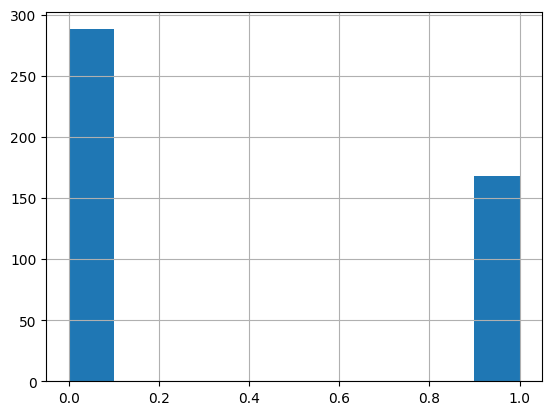

In [460]:
df["fire"].hist()

In [461]:
targetName = "fire"
allFeatureNames = df.columns[df.columns != targetName]
allFeatureNames = allFeatureNames[allFeatureNames != "collector.id"]
allFeatureNames = allFeatureNames[allFeatureNames != "rain"]
allFeatureNames = allFeatureNames[allFeatureNames != "humidity"]
X = df[allFeatureNames]
y = df[targetName]

In [462]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [463]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [464]:
y_train = y_train[X_train["l.score"].notnull()]
y_train = y_train[X_train["tree.age"].notnull()]
y_train = y_train[X_train["wind.intensity"].notnull()]
X_train.dropna(inplace=True)

In [465]:
y_train = y_train[X_train["c.score"]<100] 
X_train = X_train[X_train["c.score"]<100]
y_train = y_train[X_train["tree.age"]<200] 
X_train = X_train[X_train["tree.age"]<200]

In [466]:
mm_scaler = MinMaxScaler()
X_train = pd.DataFrame(mm_scaler.fit_transform(X_train), columns=X_train.columns)

In [467]:
oversample = over_sampling.SMOTE(random_state=1)
X_train_balanced, y_train_balanced = oversample.fit_resample(X_train, y_train)

### Logistic Regression

In [468]:
parametersLR = dict(solver=["liblinear","lbfgs","sag",],
                    penalty=['l2'],
                    max_iter=[None, 2000, 5000])

In [469]:
lR_balanced = LogisticRegression(random_state=1)
lR_clf_balanced = GridSearchCV(lR_balanced, parametersLR, scoring="f1_macro").fit(X_train_balanced, y_train_balanced)

In [470]:
y_validation = y_validation[X_validation["l.score"].notnull()]
y_validation = y_validation[X_validation["tree.age"].notnull()]
y_validation = y_validation[X_validation["wind.intensity"].notnull()]
X_validation.dropna(inplace=True)

In [471]:
y_validation = y_validation[X_validation["c.score"]<100] 
X_validation = X_validation[X_validation["c.score"]<100]
y_validation = y_validation[X_validation["tree.age"]<200]
X_validation = X_validation[X_validation["tree.age"]<200]

In [472]:
mm_scaler = MinMaxScaler()
X_validation = pd.DataFrame(mm_scaler.fit_transform(X_validation), columns=X_validation.columns)

In [473]:
oversample = over_sampling.SMOTE(random_state=1)
X_validation_balanced, y_validation_balanced = oversample.fit_resample(X_validation, y_validation)

In [474]:
print(lR_clf_balanced.best_params_)
print(round(metrics.f1_score(lR_clf_balanced.best_estimator_.predict(X_validation_balanced), y_validation_balanced, average="macro"), 3))

{'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.853


In [475]:
print("R2:", metrics.r2_score(y_validation_balanced, lR_clf_balanced.best_estimator_.predict(X_validation_balanced)))

R2: 0.41666666666666663


**Manual Search** of hyperparameters

**Logistic Regression** with *{'solver':'sag','penalty':'l2','max_iter':5000}*

In [476]:
lR2_balanced = LogisticRegression(solver='sag', penalty='l2', max_iter=5000, random_state=1).fit(X_train_balanced, y_train_balanced)
y_lR2_balanced = lR2_balanced.predict_proba(X_validation_balanced)[:,1]
y_lR2_balanced = [round(y) for y in y_lR2_balanced]

In [477]:
print(f"The F1 score is: {round(metrics.f1_score(y_lR2_balanced, y_validation_balanced, average='macro'),3)}")

The F1 score is: 0.853


**Logistic Regression** with *{'solver':'liblinear','penalty':'l2'}*

In [478]:
lR3_balanced = LogisticRegression(solver='liblinear', penalty='l2', random_state=1).fit(X_train_balanced, y_train_balanced)
y_lR3_balanced = lR3_balanced.predict_proba(X_validation_balanced)[:,1]
y_lR3_balanced = [round(y) for y in y_lR3_balanced]

In [479]:
print(f"The F1 score is: {round(metrics.f1_score(y_lR3_balanced, y_validation_balanced, average='macro'),3)}")

The F1 score is: 0.853


**Logistic Regression** with default hyperparameters (*{'penalty':'l2','solver':'lbfgs','max_iter':100}*)

In [480]:
lR4_balanced = LogisticRegression(random_state=1).fit(X_train_balanced, y_train_balanced)
y_lR4_balanced = lR4_balanced.predict_proba(X_validation_balanced)[:,1]
y_lR4_balanced = [round(y) for y in y_lR4_balanced]

In [481]:
print(f"The F1 score is: {round(metrics.f1_score(y_lR4_balanced, y_validation_balanced, average='macro'),3)}")

The F1 score is: 0.853


### Decision Tree

In [482]:
parametersDT = dict(criterion=["gini","entropy","log_loss",],
                    max_depth=[None, 6, 20])

In [483]:
tree_clf_balanced = tree.DecisionTreeClassifier(random_state=1)
tree_Grid_balanced = GridSearchCV(tree_clf_balanced, parametersDT, scoring="f1_macro").fit(X_train_balanced, y_train_balanced)

In [484]:
print(tree_Grid_balanced.best_params_)
print(round(metrics.f1_score(tree_Grid_balanced.best_estimator_.predict(X_validation_balanced), y_validation_balanced, average="macro"), 3))

{'criterion': 'entropy', 'max_depth': None}
0.833


In [485]:
print("R2:", metrics.r2_score(y_validation_balanced, tree_Grid_balanced.best_estimator_.predict(X_validation_balanced)))

R2: 0.33333333333333337


**Manual Search** of hyperparameters

**DecisionTree** with hyperparameters *{'criterion':'gini'}*

In [486]:
tree_clf1_balanced = tree.DecisionTreeClassifier(criterion="gini",random_state=1).fit(X_train_balanced, y_train_balanced)
y_DTC1_balanced = tree_clf1_balanced.predict(X_validation_balanced)

In [487]:
print(f"The F1 score is: {round(metrics.f1_score(y_DTC1_balanced, y_validation_balanced, average='macro'),3)}")

The F1 score is: 0.885


**DecisionTree** with hyperparameters *{'criterion':'log_loss'}*

In [488]:
tree_clf3_balanced = tree.DecisionTreeClassifier(criterion="log_loss",random_state=1).fit(X_train_balanced, y_train_balanced)
y_DTC3_balanced = tree_clf3_balanced.predict(X_validation_balanced)

In [489]:
print(f"The F1 score is: {round(metrics.f1_score(y_DTC3_balanced, y_validation_balanced, average='macro'),3)}")

The F1 score is: 0.833


**DecisionTree** with hyperparameters *{'criterion':'gini','max_depth':6}*

In [490]:
tree_clf2_balanced = tree.DecisionTreeClassifier(criterion="gini",max_depth=6,random_state=1).fit(X_train_balanced, y_train_balanced)
y_DTC2_balanced = tree_clf2_balanced.predict(X_validation_balanced)

In [491]:
print(f"The F1 score is: {round(metrics.f1_score(y_DTC2_balanced, y_validation_balanced, average='macro'),3)}")

The F1 score is: 0.885


### RandomForest

In [492]:
parametersRF = dict(criterion=["gini","entropy","log_loss",],
                    n_estimators=[10,50,100],
                    max_depth=[None, 6, 20])

In [493]:
rf_clf_balanced = RandomForestClassifier(random_state=1)
rf_Grid_balanced = GridSearchCV(rf_clf_balanced, parametersRF, scoring="f1_macro").fit(X_train_balanced, y_train_balanced)

In [494]:
print(rf_Grid_balanced.best_params_)
print(round(metrics.f1_score(rf_Grid_balanced.best_estimator_.predict(X_validation_balanced), y_validation_balanced, average="macro"), 3))

{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 50}
0.853


In [495]:
print("R2:", metrics.r2_score(y_validation_balanced, rf_Grid_balanced.best_estimator_.predict(X_validation_balanced)))

R2: 0.41666666666666663


**RandomForest** with *{'n_estimators'=50,'criterion'='log_loss'}*

In [496]:
rf1_balanced = RandomForestClassifier(n_estimators=50, random_state=1, criterion="log_loss").fit(X_train_balanced, y_train_balanced)
y_rf1_balanced = rf1_balanced.predict(X_validation_balanced)

In [497]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf1_balanced, y_validation_balanced, average='macro'),3)}")

The F1 score is: 0.853


**RandomForest** with *{'n_estimator'=25, 'random_state'=1}*

In [498]:
rf2_balanced = RandomForestClassifier(n_estimators=25, random_state=1).fit(X_train_balanced, y_train_balanced)
y_rf2_balanced = rf2_balanced.predict(X_validation_balanced)

In [499]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf2_balanced, y_validation_balanced, average='macro'),3)}")

The F1 score is: 0.853


**RandomForest** with *{'n_estimator'=50,'max_depth'=6,'criterion'='entropy','random_state'=1}*

In [500]:
rf3_balanced = RandomForestClassifier(n_estimators=50, max_depth=6, criterion='entropy',random_state=1).fit(X_train_balanced, y_train_balanced)
y_rf3_balanced = rf3_balanced.predict(X_validation_balanced)

In [501]:
print(f"The F1 score is: {round(metrics.f1_score(y_rf3_balanced, y_validation_balanced, average='macro'),3)}")

The F1 score is: 0.853


### Neural Networks

In [502]:
parametersNN = dict(activation=["relu","logistic","tanh","identity"],
                    learning_rate_init=[0.001,0.01,0.05],
                    solver=["adam", "sgd", "lbfgs"],
                    max_iter=[200, 800, 1400],
                    hidden_layer_sizes=[(10),(5,5),(5,5,5)])

In [503]:
mlp_clf_balanced = MLPClassifier(random_state=1)
mlp_Grid_balanced = GridSearchCV(mlp_clf_balanced, parametersNN, scoring="f1_macro").fit(X_train_balanced, y_train_balanced)

In [504]:
print(mlp_Grid_balanced.best_params_)
print(round(metrics.f1_score(mlp_Grid_balanced.best_estimator_.predict(X_validation_balanced), y_validation_balanced, average="macro"), 3))

{'activation': 'relu', 'hidden_layer_sizes': (5, 5, 5), 'learning_rate_init': 0.01, 'max_iter': 200, 'solver': 'adam'}
0.864


In [505]:
print("R2:", metrics.r2_score(y_validation_balanced, mlp_Grid_balanced.best_estimator_.predict(X_validation_balanced)))

R2: 0.45833333333333337


**Manual Search** of hyperparameter

**MLPClassifier** with hyperparameters *{'solver':'adam','hidden_layer_sizes':(5,5),'max_iter':2000,'activations':'logistic'}*

In [506]:
mlp1_balanced = MLPClassifier(solver='adam', hidden_layer_sizes=(5,5), max_iter=2000, activation='logistic', random_state=1).fit(X_train_balanced, y_train_balanced)
y_MLP1_balanced = mlp1_balanced.predict(X_validation_balanced)

In [507]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP1_balanced, y_validation_balanced, average='macro'),3)}")

The F1 score is: 0.875


**MLPClassifier** with hyperparameters *{'solver':'relu','hidden_layer_sizes':(10),'activation':'logistic'}*

In [508]:
mlp2_balanced = MLPClassifier(solver='adam', hidden_layer_sizes=(10), activation='relu', random_state=1).fit(X_train_balanced, y_train_balanced)
y_MLP2_balanced = mlp2_balanced.predict(X_validation_balanced)

In [509]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP2_balanced, y_validation_balanced, average='macro'),3)}")

The F1 score is: 0.875


**MLPClassifer** with hyperparameters *{'solver':'lbfgs','hidden_layer_sizes':10,'activation':'relu', 'learning_rate_init':0.01}*

In [510]:
mlp3_balanced = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10), activation='relu', learning_rate_init= 0.01, random_state=1).fit(X_train_balanced, y_train_balanced)
y_MLP3_balanced = mlp3_balanced.predict(X_validation_balanced)

In [511]:
print(f"The F1 score is: {round(metrics.f1_score(y_MLP3_balanced, y_validation_balanced, average='macro'),3)}")

The F1 score is: 0.896


## Best model for balanced data

The best model I could find for the balanced data via *SMOTE* is **MLPClassifier** with the following hyperparameters:
 - 'solver'='lbfgs'
 - 'hidden_layer_sizes'=(10)
 - 'activation'='relu'
 - 'learning_rate_init': 0.001
 - 'max_iter': 200

To see if the model chosen is actually as good as it seems I will use it to predict the test data and see how good its prediction power.

As the **MLPClassifier** does not accept null values natively, I will perform the same modification on the test dataset to the one performed to the training and test datasets.

In [512]:
y_test = y_test[X_test["l.score"].notnull()]
y_test = y_test[X_test["tree.age"].notnull()]
y_test = y_test[X_test["wind.intensity"].notnull()]
X_test.dropna(inplace=True)

In [513]:
mm_scaler = MinMaxScaler()
X_test = pd.DataFrame(mm_scaler.fit_transform(X_test), columns=X_test.columns)

In [514]:
y_balanced_Best = mlp3_balanced.predict(X_test)

In [515]:
print(round(metrics.f1_score(y_balanced_Best, y_test, average='macro'),3))

0.932


In [516]:
print("R2:", metrics.r2_score(y_test, y_balanced_Best))

R2: 0.7288977159880834


As the best model is the one without the variables *rain* and *humidity*, I will now plot its respective confussion matrix.

**Note**: The model with all the variables and the data normalised it's slightly better (by 0.001), but I have chosen the former one following the KISS principle, which aims to always go for the most simple model, which I feel in this case is the one with less variables.

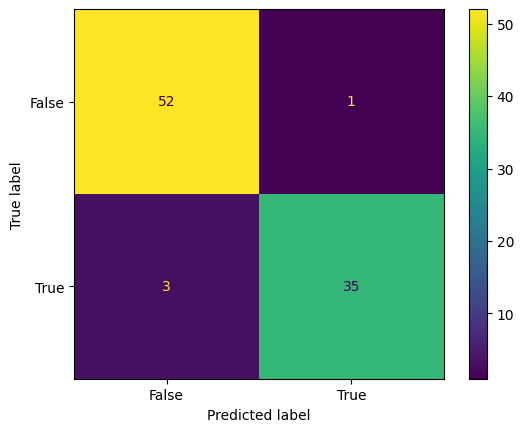

In [517]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

confusion_matrix = confusion_matrix(y_test, y_uncorr6_Best)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

# Conclussion

After applying various modifications to the dataset and training different models with them, the best model obtained was an *MLPClassifier* (a Neural Network) with the following as its hyperparameters:
 - 'solver'='lbfgs'
 - 'hidden_layer_sizes'=(10)
 - 'activation'='relu'
 - 'learning_rate_init': 0.001
 - 'max_iter': 200

The score of the metric used (*F1 Score*) was of 93.7% with the validation set and 95.5% with the testing dataset. 

The modifications perfomed over the dataset used to train this model were the following:
- Removing the columns "*c.score*" and "*collector.id*"
- Filling the null values of the columns with their respective mean. **Note**: This was done after perfoming the train-validation-test split.
- Remove the existant outliers of the column "*tree.age*".
- Perfoming *SMOTE* over the target feature. 